In [1]:
import numpy as np
import pandas as pd
from pprint import pprint

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Dataset
import time
import scipy.stats

import random
import math
from torch.utils.tensorboard import SummaryWriter

import copy
from typing import Any, Callable, Optional, Tuple

random.seed(50)
np.random.seed(50)
torch.manual_seed(50)
torch.cuda.manual_seed_all(50)
torch.backends.cudnn.deterministic = True

from resnet import resnet18
from mobilenet import mobilenet_v2

import matplotlib.pyplot as plt


print(torch.__version__, torchvision.__version__)

1.12.1 0.13.1


In [2]:
class MlpNet(nn.Module):
    def __init__(self,dstName):
        super().__init__()
        if dstName == "MINIST":
            num_in = 28 * 28
            num_hid = 64
            num_out = 10
        else:
            num_in = 32 * 32 * 3
            num_hid = 64
            num_out = 10
        self.body = nn.Sequential(
            nn.Linear(num_in,num_hid),
            nn.ReLU(),
            nn.Linear(num_hid,num_hid),
            nn.ReLU(),
            nn.Linear(num_hid,num_out)
        )
    def forward(self,x):
        x = x.view(x.size(0), -1)
        return self.body(x)

class CnnNet(nn.Module):
    def __init__(self, dstName):
        super().__init__()
        if dstName == 'CIFAR10':
            # input [3, 32, 32]
            self.body = nn.Sequential(
                nn.Conv2d(3, 10, kernel_size=5, padding=1, stride=1), # [10, 32, 32]
                nn.BatchNorm2d(10),
                nn.ReLU(),
                nn.MaxPool2d(2,2,0),# [10, 16, 16]

                nn.Conv2d(10, 20, kernel_size=5, padding=1, stride=1), # [20, 16, 16]
                nn.BatchNorm2d(20),
                nn.ReLU(),
                nn.MaxPool2d(2,2,0),#[20, 6, 6]
            )
            self.fc = nn.Sequential(
                nn.Linear(20*6*6, 84),
                nn.Linear(84, 10)
            )
        if dstName == 'MINIST':
            # input [1, 28, 28]
            self.body = nn.Sequential(
                nn.Conv2d(1, 5, kernel_size=5, padding=1, stride=1), # [5, 28, 28]
                nn.BatchNorm2d(5),
                nn.ReLU(),
                nn.MaxPool2d(2,2,0),# [5, 14, 14]

                nn.Conv2d(5, 10, kernel_size=5, padding=1, stride=1), # [10, 14, 14]
                nn.BatchNorm2d(10),
                nn.ReLU(),
                nn.MaxPool2d(2,2,0),#[10, 7, 7]
            )
            self.fc = nn.Sequential(
                nn.Linear(250, 84),
                nn.Linear(84, 10)
            )
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        return self.fc(out)

class ResNet18(nn.Module):
    def __init__(self, dstName):
        super().__init__()
        if dstName == 'CIFAR10':
            self.body = resnet18(pretrained=False,n_classes=10,input_channels=3)
        if dstName == 'MINIST':
            self.body = resnet18(pretrained=False,n_classes=10,input_channels=1)
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        return out

class MobileNetV2(nn.Module):
    def __init__(self, dstName):
        super().__init__()
        if dstName == 'CIFAR10':
            self.body = mobilenet_v2(pretrained=False,n_class=10,i_channel=3,input_size=32)
        if dstName == 'MINIST':
            self.body = mobilenet_v2(pretrained=False,n_class=10,i_channel=1,input_size=28)
    def forward(self,x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        return out

class Classifier(nn.Module):
    def __init__(self, netName, dstName):
        super().__init__()
        if netName == 'CNN':
            self.body = CnnNet(dstName)
        if netName == 'MLP':
            self.body = MlpNet(dstName)
        if netName == 'RESNET18':
            self.body = ResNet18(dstName)
        if netName == 'MOBILENETV2':
            self.body = MobileNetV2(dstName)
    def forward(self,x):
        return self.body(x)

In [3]:
def updateScoresV6(args):
    """
        rule 1: 若准确率创新高且经历过准确率下降，则 +k*0.3
        rule 2: 若准确率降低，且小于最近n轮准确率平均值，则根据下降程度减去不同程度的分数
        通过谨慎的加分策略，可以避免恶意客户端搭便车加分
        以最近n轮准确率平均值为基准，评判准确率下降属于正常波动还是因为劣质数据过多，可以有效避免优质客户端被减分，
        提升评分的稳定性，当所有节点数据质量接近时，节点的评分也会接近
    """
    CLIENT_N = args['CLIENT_N']
    acc_logs = args['acc_logs']
    scores = args['scores']
    prev_participants = args['prev_participants']
    participants = args['participants']
    round = args['round']
    deltaAcc = args['deltaAcc']
    expAcc_logs = args['expAcc_logs']
    beta = args['beta']
    
    result = {
        'scores':scores,
        'deltaAcc':deltaAcc,
        'expAcc_logs':expAcc_logs,
        'v6flag':0
    }
    if 'bound' not in args:
        args['bound'] = 3

    if round == 0:
        return result
    for cId in range(CLIENT_N):
        scores[cId][round] = scores[cId][round-1]
    if round >= args['bound']:
        lowBound = round-args['bound']
    else:
        lowBound = 0
    nowAcc = acc_logs[round]
    preAcc = acc_logs[round-1]
    maxAcc = np.max(acc_logs[:round])
    expAcc = np.average(acc_logs[lowBound:round])
    result['expAcc_logs'].append(expAcc)
    result['deltaAcc'] = deltaAcc
    s = 0
    k = 1
    if nowAcc <= preAcc:
        result['v6flag'] = args['v6flag'] + 1
    else:
        result['v6flag'] = args['v6flag']
     
    if args['v6flag'] >= 0 and (nowAcc-0) > maxAcc:
        for cId in participants:
            scores[cId][round] += k*0.3
    if nowAcc < expAcc and nowAcc < preAcc:
        dif = preAcc - nowAcc
        if dif < 0.1*preAcc:
            s = k
        elif dif < 0.2*preAcc:
            s = k*3
        elif dif < 0.3*preAcc:
            s = k*6
        else:
            s = k*8
        for cId in participants:
            scores[cId][round] -= s
        
    return result

def updateScoresV7(args):
    """
        rule 1: 若准确率创新高且经历过准确率下降，则 +k*0.3
        rule 2: 若准确率降低，且小于最近n轮准确率平均值，则根据下降程度减去不同程度的分数
        通过谨慎的加分策略，可以避免恶意客户端搭便车加分
        以最近n轮准确率平均值为基准，评判准确率下降属于正常波动还是因为劣质数据过多，可以有效避免优质客户端被减分，
        提升评分的稳定性，当所有节点数据质量接近时，节点的评分也会接近
    """
    CLIENT_N = args['CLIENT_N']
    acc_logs = args['acc_logs']
    scores = args['scores']
    prev_participants = args['prev_participants']
    participants = args['participants']
    round = args['round']
    deltaAcc = args['deltaAcc']
    expAcc_logs = args['expAcc_logs']
    beta = args['beta']
    
    result = {
        'scores':scores,
        'deltaAcc':deltaAcc,
        'expAcc_logs':expAcc_logs,
        'v6flag':0
    }
    if 'bound' not in args:
        args['bound'] = 3

    if round == 0:
        return result
    for cId in range(CLIENT_N):
        scores[cId][round] = scores[cId][round-1]
    if round >= args['bound']:
        lowBound = round-args['bound']
    else:
        lowBound = 0
    nowAcc = acc_logs[round]
    preAcc = acc_logs[round-1]
    maxAcc = np.max(acc_logs[:round])
    expAcc = np.average(acc_logs[lowBound:round])
    result['expAcc_logs'].append(expAcc)
    result['deltaAcc'] = deltaAcc
    s = 0
    k = preAcc
    if nowAcc <= preAcc:
        result['v6flag'] = args['v6flag'] + 1
    else:
        result['v6flag'] = args['v6flag']
     
    dif = nowAcc - preAcc
    stdDif = expAcc - preAcc
    
    # if nowAcc > maxAcc and args['v6flag'] >= 0:
    if dif > 0 and args['v6flag'] >= 0:
        if (stdDif>0 and dif>=stdDif) or (stdDif < 0):
            # s = k*2**(int((dif*1.0/preAcc)*10))
            # s= k*(dif*1.0/preAcc)*100
            s = (1+preAcc)**10*(preAcc*dif)
    if dif < 0:
        if (stdDif<0 and dif<=stdDif) or (stdDif > 0):
            # s = -k*2**(int((-dif*1.0/preAcc)*10))
            # s = k*(dif*1.0/preAcc)*100
            s = (1+preAcc)**10*(preAcc*dif)
    for cId in participants:
        scores[cId][round] += s
        
    return result

def updateScoresV5(args):
    """
        rule 1: 若准确率创新高且经历过准确率下降，则 +k*0.3
        rule 2: 若准确率降低，且小于最近n轮准确率平均值，则根据下降程度减去不同程度的分数
        通过谨慎的加分策略，可以避免恶意客户端搭便车加分
        以最近n轮准确率平均值为基准，评判准确率下降属于正常波动还是因为劣质数据过多，可以有效避免优质客户端被减分，
        提升评分的稳定性，当所有节点数据质量接近时，节点的评分也会接近
    """
    CLIENT_N = args['CLIENT_N']
    acc_logs = args['acc_logs']
    scores = args['scores']
    prev_participants = args['prev_participants']
    participants = args['participants']
    round = args['round']
    deltaAcc = args['deltaAcc']
    expAcc_logs = args['expAcc_logs']
    beta = args['beta']
    
    result = {
        'scores':scores,
        'deltaAcc':deltaAcc,
        'expAcc_logs':expAcc_logs,
        'v6flag':0
    }
    if 'bound' not in args:
        args['bound'] = 3

    if round == 0:
        return result
    for cId in range(CLIENT_N):
        scores[cId][round] = scores[cId][round-1]
    if round >= args['bound']:
        lowBound = round-args['bound']
    else:
        lowBound = 0
    nowAcc = acc_logs[round]
    preAcc = acc_logs[round-1]
    maxAcc = np.max(acc_logs[:round])
    expAcc = np.average(acc_logs[lowBound:round])
    result['expAcc_logs'].append(expAcc)
    result['deltaAcc'] = deltaAcc
    s = 0
    k = preAcc
    if nowAcc <= preAcc:
        result['v6flag'] = args['v6flag'] + 1
    else:
        result['v6flag'] = args['v6flag']

    dif1 = nowAcc - preAcc
    dif2 = nowAcc - expAcc
    if dif1*dif2 > 0:
        # s = (1+preAcc)**10*(preAcc*dif1)
        s = (1+preAcc)**25*(dif1)

    for cId in participants:
        scores[cId][round] += s
        
    return result

def updateScoresV4(args):
    CLIENT_N = args['CLIENT_N']
    acc_logs = args['acc_logs']
    scores = args['scores']
    prev_participants = args['prev_participants']
    participants = args['participants']
    round = args['round']
    deltaAcc = args['deltaAcc']
    expAcc_logs = args['expAcc_logs']
    
    result = {
        'scores':scores,
        'deltaAcc':deltaAcc,
        'expAcc_logs':expAcc_logs
    }

    if round == 0:
        return result
    result['expAcc_logs'].append(acc_logs[round-1])
    for cId in range(CLIENT_N):
        scores[cId][round] = scores[cId][round-1]
    if acc_logs[round] < acc_logs[round-1]:
        for cId in participants:
            scores[cId][round] -= 1

    return result

def updateScoresV3(args):
    """
        rule 1: 若准确率创新高，则 +2
        rule 2: 若准确率比期望值高，最高值低，则 +0.5
        rule 3: 若准确率比期望值低，且差值低于期望值与最高值的差，则 -0.5
        rule 4： 若准确率比期望值低，且差值大于期望值与最高值的差，则 -2
    """
    CLIENT_N = args['CLIENT_N']
    acc_logs = args['acc_logs']
    scores = args['scores']
    prev_participants = args['prev_participants']
    participants = args['participants']
    round = args['round']
    deltaAcc = args['deltaAcc']
    expAcc_logs = args['expAcc_logs']
    
    result = {
        'scores':scores,
        'deltaAcc':deltaAcc,
        'expAcc_logs':expAcc_logs
    }
    

    if round == 0:
        return result
    for cId in range(CLIENT_N):
        scores[cId][round] = scores[cId][round-1]
    if round == 1:
        if acc_logs[round] < acc_logs[round-1]:
            for cId in participants:
                scores[cId][round] -= 2
        else:
            deltaAcc = acc_logs[round]-acc_logs[round-1]
            deltaAcc = (1-acc_logs[round])*(1-math.exp(-deltaAcc))
        result['deltaAcc'] = deltaAcc
        return result
    #calculate expAcc for this round
    # print(f'round={round}, deltaAcc={deltaAcc}, acc_logs[round-1]={acc_logs[round-1]}, acc_logs[round]={acc_logs[round]}, maxAcc={np.max(acc_logs[:round])}, preMaxAcc={np.max(acc_logs[:round-1])}')

    preMaxAcc = np.max(acc_logs[:round-1])
    if acc_logs[round-1] < preMaxAcc:
        expAcc = preMaxAcc
    else:
        expAcc = acc_logs[round-1] + deltaAcc
    expAcc_logs.append(expAcc)

    nowAcc = acc_logs[round]
    maxAcc = np.max(acc_logs[:round])
    beta = 0.1
    if acc_logs[round] > maxAcc:
        deltaAcc = (1-beta)*deltaAcc + beta*(acc_logs[round]-maxAcc)
        deltaAcc = (1-acc_logs[round])*(1 - math.exp(-deltaAcc))
    result['deltaAcc'] = deltaAcc
    
    if nowAcc > maxAcc and nowAcc-maxAcc > expAcc_logs[round]-expAcc_logs[round-1]:
        for cId in participants:
            scores[cId][round] += 0.5
        return result
    if nowAcc > maxAcc and nowAcc-maxAcc < expAcc_logs[round]-expAcc_logs[round-1]:
        for cId in participants:
            scores[cId][round] += 2
        return result
    for cId in participants:
        scores[cId][round] -= 2
    return result

def updateScoresV2(args):
    """
        rule 1: 若准确率创新高，则 +2
        rule 2: 若准确率比期望值高，最高值低，则 +0.5
        rule 3: 若准确率比期望值低，且差值低于期望值与最高值的差，则 -0.5
        rule 4： 若准确率比期望值低，且差值大于期望值与最高值的差，则 -2
    """
    CLIENT_N = args['CLIENT_N']
    acc_logs = args['acc_logs']
    scores = args['scores']
    prev_participants = args['prev_participants']
    participants = args['participants']
    round = args['round']
    deltaAcc = args['deltaAcc']
    expAcc_logs = args['expAcc_logs']
    beta = args['beta']
    
    result = {
        'scores':scores,
        'deltaAcc':deltaAcc,
        'expAcc_logs':expAcc_logs
    }

    if round == 0:
        result['deltaAcc'] = deltaAcc
        return result
    for cId in range(CLIENT_N):
        scores[cId][round] = scores[cId][round-1]
    if round == 1:
        if acc_logs[round] < acc_logs[round-1]:
            for cId in participants:
                scores[cId][round] -= 2
        else:
            deltaAcc = acc_logs[round] - acc_logs[round-1]
        result['deltaAcc'] = deltaAcc
        return result
    nowAcc = acc_logs[round]
    maxAcc = np.max(acc_logs[:round])
    expAcc = acc_logs[round-1] + deltaAcc
    expAcc_logs.append(expAcc)
    
    # beta = 0.1
    deltaAcc = (1-beta)*deltaAcc + beta*(acc_logs[round]-acc_logs[round-1])
    result['deltaAcc'] = deltaAcc
    if nowAcc >= maxAcc:
        for cId in participants:
            scores[cId][round] += 2
        return result
    if maxAcc < expAcc:
        for cId in participants:
            scores[cId][round] -= 2
        return result
    if maxAcc > expAcc:
        if nowAcc < expAcc:
            for cId in participants:
                scores[cId][round] -= 2
            return result
        if nowAcc >= expAcc:
            for cId in participants:
                scores[cId][round] += 0.5
            return result
    return result

def updateScoresV1(args):
    """
        rule 1: 若准确率创新高，则 +2
        rule 2: 若准确率比期望值高，最高值低，则 +0.5
        rule 3: 若准确率比期望值低，且差值低于期望值与最高值的差，则 -0.5
        rule 4： 若准确率比期望值低，且差值大于期望值与最高值的差，则 -2
    """
    CLIENT_N = args['CLIENT_N']
    acc_logs = args['acc_logs']
    scores = args['scores']
    prev_participants = args['prev_participants']
    participants = args['participants']
    round = args['round']
    deltaAcc = args['deltaAcc']
    expAcc_logs = args['expAcc_logs']
    beta = args['beta']
    
    result = {
        'scores':scores,
        'deltaAcc':deltaAcc,
        'expAcc_logs':expAcc_logs,
        'v6flag':0
    }

    if round == 0:
        return result
    for cId in range(CLIENT_N):
        scores[cId][round] = scores[cId][round-1]
    if round == 1:
        if acc_logs[round] < acc_logs[round-1]:
            for cId in participants:
                scores[cId][round] -= 2
        else:
            deltaAcc = acc_logs[round] - acc_logs[round-1]
        result['deltaAcc'] = deltaAcc
        return result
    nowAcc = acc_logs[round]
    maxAcc = np.max(acc_logs[:round])
    expAcc = acc_logs[round-1] + deltaAcc
    result['expAcc_logs'].append(expAcc)
    # beta = 0.1
    deltaAcc = (1-beta)*deltaAcc + beta*(acc_logs[round]-acc_logs[round-1])
    result['deltaAcc'] = deltaAcc
    if nowAcc >= maxAcc:
        for cId in participants:
            scores[cId][round] += 2
        return result
    if maxAcc < expAcc:
        for cId in participants:
            scores[cId][round] -= 2
        return result
    if maxAcc > expAcc:
        if nowAcc < expAcc:
            for cId in participants:
                scores[cId][round] -= 2
            return result
    return result

def updateScoresV0(args):
    """
        rule 1: 若准确率创新高，则 +2
        rule 2: 若准确率比期望值高，最高值低，则 +0.5
        rule 3: 若准确率比期望值低，且差值低于期望值与最高值的差，则 -0.5
        rule 4： 若准确率比期望值低，且差值大于期望值与最高值的差，则 -2
    """
    CLIENT_N = args['CLIENT_N']
    acc_logs = args['acc_logs']
    scores = args['scores']
    prev_participants = args['prev_participants']
    participants = args['participants']
    round = args['round']
    deltaAcc = args['deltaAcc']

    if round == 0:
        return scores, deltaAcc
    for cId in range(CLIENT_N):
        scores[cId][round] = scores[cId][round-1]
    if round == 1:
        if acc_logs[round] < acc_logs[round-1]:
            for cId in participants:
                scores[cId][round] -= 2
        return scores, deltaAcc
    nowAcc = acc_logs[round]
    maxAcc = np.max(acc_logs[:round])
    expAcc = (np.sum(acc_logs[:round]) - maxAcc) * 0.3 + maxAcc * 0.7
    if nowAcc > maxAcc:
        for cId in participants:
            scores[cId][round] += 2
        return scores, deltaAcc
    if nowAcc > expAcc and (nowAcc - expAcc) < (maxAcc - expAcc):
        for cId in participants:
            scores[cId][round] += 0.5
        return scores, deltaAcc
    if nowAcc < expAcc and (expAcc - nowAcc) < (maxAcc - expAcc):
        for cId in participants:
            scores[cId][round] -= 0.5
        return scores, deltaAcc
    if nowAcc < expAcc and (expAcc - nowAcc) > (maxAcc - expAcc):
        for cId in participants:
            scores[cId][round] -= 2
        return scores, deltaAcc
    return scores, deltaAcc

def updateScores(args):
    CLIENT_N = args['CLIENT_N']
    acc_logs = args['acc_logs']
    scores = args['scores']
    prev_participants = args['prev_participants']
    participants = args['participants']
    round = args['round']
    deltaAcc = args['deltaAcc']
    expAcc_logs = args['expAcc_logs']
    
    result = {
        'scores':scores,
        'deltaAcc':deltaAcc,
        'expAcc_logs':expAcc_logs,
        'v6flag':0
    }

    if round == 0:
        return result
    for cId in range(CLIENT_N):
        scores[cId][round] = scores[cId][round-1]
    
    nowAcc = acc_logs[round]
    preAcc = acc_logs[round-1]
    if nowAcc <= preAcc:
        result['v6flag'] = args['v6flag'] + 1
    else:
        result['v6flag'] = args['v6flag']
     
    if round > 1 and args['v6flag'] >= 0:
        if acc_logs[round] - acc_logs[round-1] > acc_logs[round-1] - acc_logs[round-2]:
            for cId in prev_participants:
                    scores[cId][round] -= 1
            for cId in participants:
                    scores[cId][round] += 1
    if acc_logs[round] - acc_logs[round-1] < 0:
        for cId in participants:
            scores[cId][round] -= 1

    return result

In [4]:
def calc_scores(params,score_version):
    scores = []
    Round = len(params['acc_logs'])
    Client_n = params['client_n']
    for c in range(Client_n):
        scores.append([0 for r in range(Round)])
    sco_res = {}
    sco_res['expAcc_logs'] = [0,0]
    sco_res['deltaAcc'] = 0
    sco_res['v6flag'] = 0
    for round in range(Round):
        args = {
        'CLIENT_N':Client_n,
        'acc_logs':params['acc_logs'],
        'round':round,
        'scores':scores,
        'deltaAcc':sco_res['deltaAcc'],
        'expAcc_logs':sco_res['expAcc_logs'],
        'v6flag':sco_res['v6flag'],
        'beta':0.2,
        'bound':params['bound'],
        }
        if round == 0:
            args['prev_participants'] = []
        else:
            args['prev_participants'] = params['ParticipantSet'][round-1]
        args['participants'] = params['ParticipantSet'][round]
        if score_version == 'origin':
            sco_res = updateScores(args)
        elif score_version == 'V1':
            sco_res = updateScoresV1(args)
        elif score_version == 'V5':
            sco_res = updateScoresV5(args)
        elif score_version == 'V7':
            sco_res = updateScoresV7(args)
        elif score_version == 'V6':
            sco_res = updateScoresV6(args)
    return sco_res

def normalization(data,maxV):
    data = np.array(data)
    _min = np.min(data)
    _max = np.max(data)
    _Max = maxV
    if _max == _min:
        return data
    return (_Max*(data-_min)/(_max-_min))

def standardization(data):
    data = np.array(data)
    mu = np.mean(data,axis=0)
    sigma = np.std(data,axis=0)
    return ((data-mu)/sigma).tolist()

def showSpearman(scores,Client_n):
    x1 = scores
    y1 = []
    for c in range(Client_n):
        y1.append(c)
        
    spearman=scipy.stats.spearmanr(x1,y1)[0]
    std=np.std(x1)
    mean = np.mean(x1)
    cov = std/mean
    return spearman,cov

In [5]:
def normScores(scores, round):
    scores = np.array(scores)
    scores = scores[:,round]
    scores = normalization(scores,100)
    return scores.tolist()

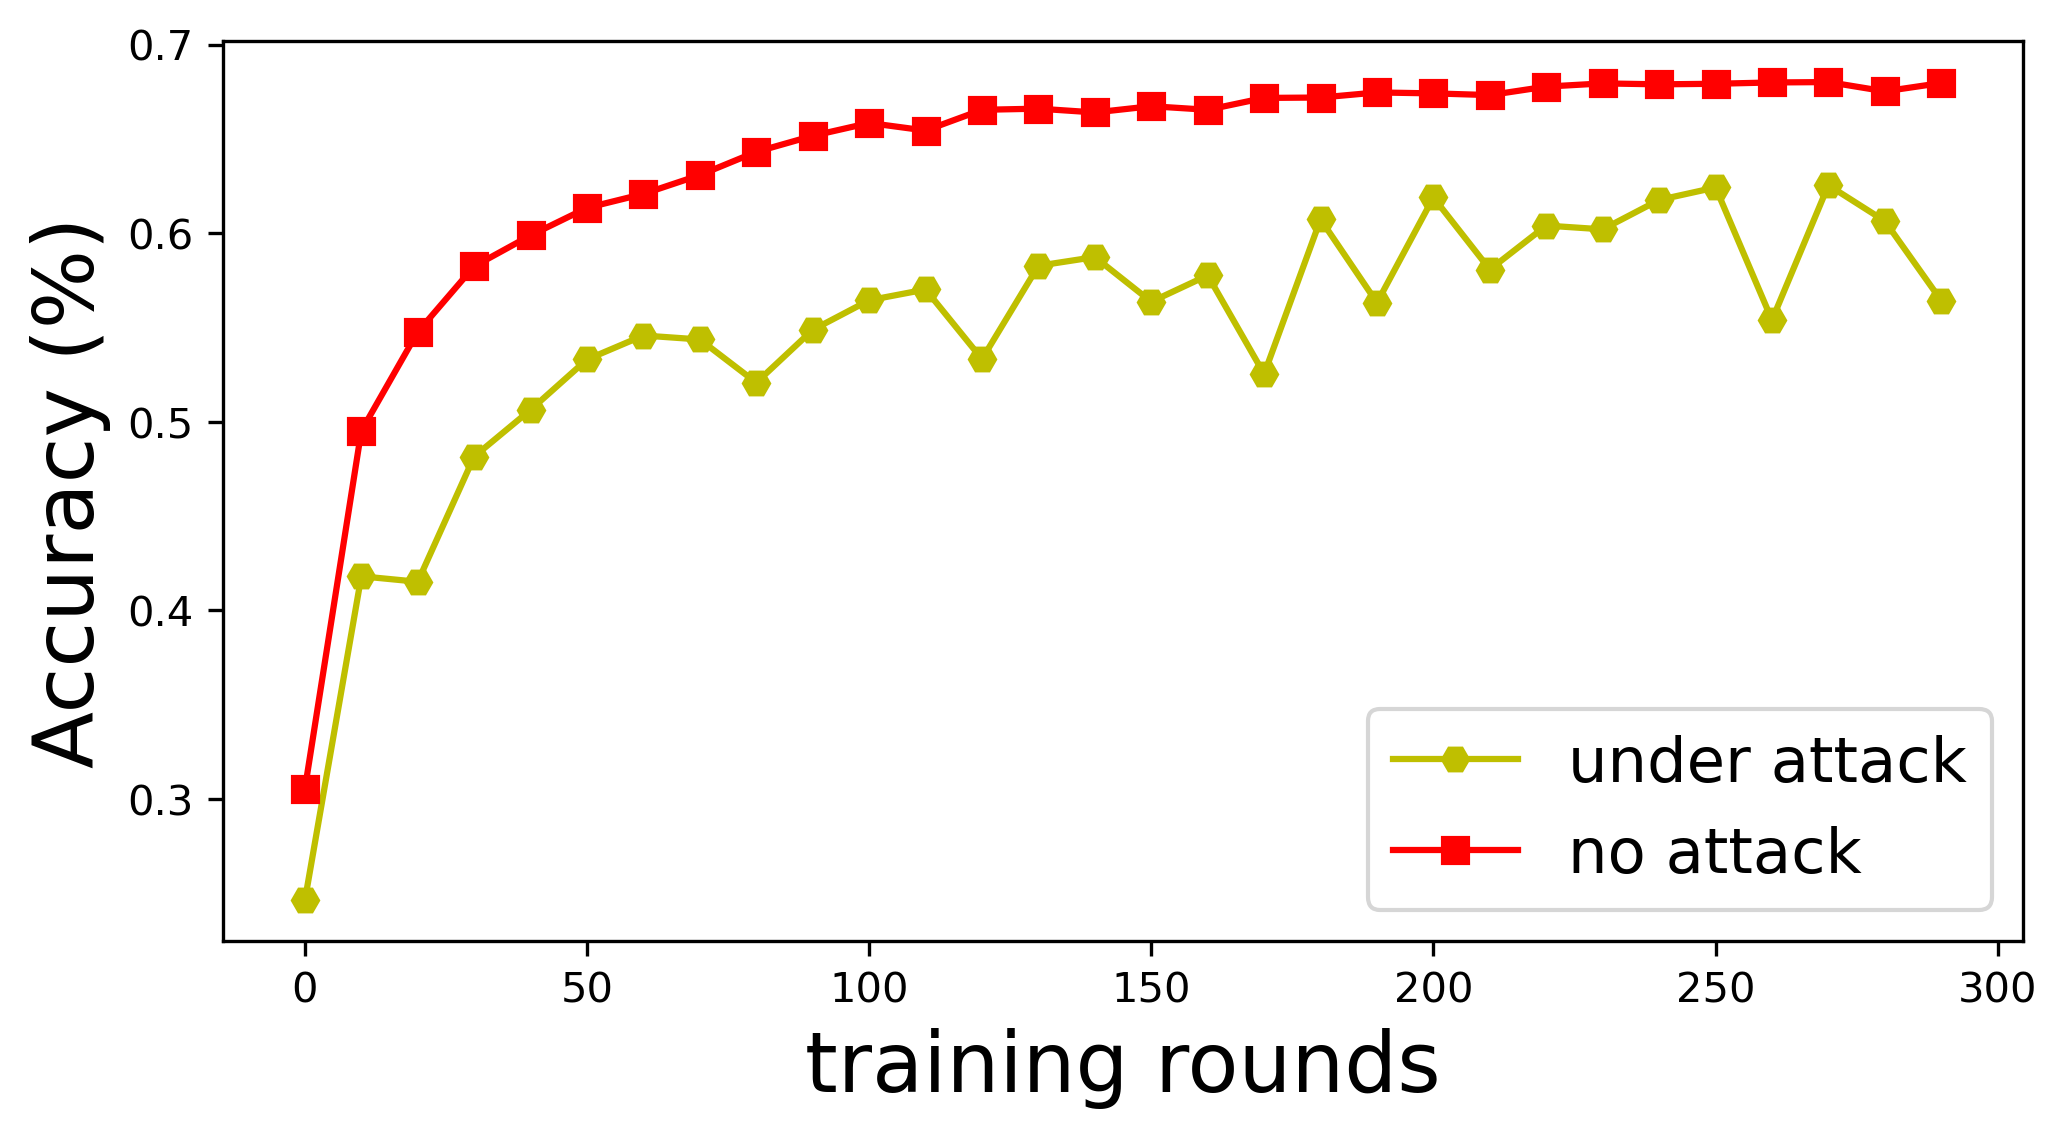

In [6]:
# Figure 1. Under Attack vs No Attack
data_dir = "acc_data13"
n_p = 25
dst_name = "CIFAR10"
netName = "CNN"
iid = 'iid'
noise = "noise"
acc_noise = torch.load(f'{data_dir}/{netName}-{dst_name}-{n_p}-{noise}-{iid}.save')['acc_logs']
noise = "nonise"
acc_nonise = torch.load(f'{data_dir}/{netName}-{dst_name}-{n_p}-{noise}-{iid}.save')['acc_logs']

x = [i for i in range(len(acc_noise))]
step_t = 10
x = x[:-1:step_t]
acc_noise = acc_noise[:-1:step_t]
acc_nonise = acc_nonise[:-1:step_t]

fig1 = plt.figure(figsize=(6,3), dpi=300)
ax = fig1.add_axes([0,0,1,1])
ax.plot(x, acc_noise, 'yH-')
ax.plot(x, acc_nonise, 'rs-')
ax.legend(labels = ('under attack', 'no attack'), loc = 'lower right', fontsize = 15)
# ax.set_title("Under Attack vs No Attack")
ax.set_xlabel('training rounds')
ax.set_ylabel('Accuracy (%)')

ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)

fig1.show()
fig1.savefig("./fig1.pdf", bbox_inches='tight')

In [7]:
rns = [0,1]
parti_n = {100:10,25:5,5:3}
data_dir = "acc_data13"
for n_p in [100,25]:
    for dst_name in ['CIFAR10','MINIST']:
        for bound in [5]:
            # netName = ['RESNET18','CNN','MLP','MOBILENETV2']
            netName = "RESNET18"
            noise = 'noise'
            iid = 'iid'
            res = torch.load(f'{data_dir}/{netName}-{dst_name}-{n_p}-{noise}-{iid}.save')
            res['bound'] = bound
            res['v6flag'] = False
            b = calc_scores(res,'origin')['scores']
            v5 = calc_scores(res,'V5')['scores']
            v7 = calc_scores(res,'V7')['scores']
            v6 = calc_scores(res,'V6')['scores']
            round = 300
            b = normScores(b,round)
            v5 = normScores(v5,round)
            v6 = normScores(v6,round)
            v7 = normScores(v7,round)
            
            # log_dir = data_dir + "/board"
            # writer = SummaryWriter(log_dir)
            # for id in range(n_p):
            #     writer.add_scalars(f'Scores-{netName}-{dst_name}/{n_p}-{noise}-{iid}',{'base':b[id]},id)
            #     writer.add_scalars(f'Scores-{netName}-{dst_name}/{n_p}-{noise}-{iid}',{'v5':v5[id]},id)
            #     writer.add_scalars(f'Scores-{netName}-{dst_name}/{n_p}-{noise}-{iid}',{'v7':v7[id]},id)

            sb,stdb = showSpearman(b,res['client_n'])
            sv7,stdv7 = showSpearman(v7,res['client_n'])
            sv5,stdv5 = showSpearman(v5,res['client_n'])
            sv6,stdv6 = showSpearman(v6,res['client_n'])
            print(f'{dst_name}-{n_p}-{noise}-{iid}-{bound}')
            print('\tspearman base:%.3f, v5:%.3f, v7:%.3f, v6:%.3f'%(sb,sv5,sv7,sv6))
            # print('\tstddevia base:%.3f, v5:%.3f, v7:%.3f, v6:%.3f'%(stdb,stdv5,stdv7,stdv6))

CIFAR10-100-noise-iid-5
	spearman base:0.667, v5:0.736, v7:0.767, v6:0.749
MINIST-100-noise-iid-5
	spearman base:0.303, v5:0.513, v7:0.487, v6:0.454
CIFAR10-25-noise-iid-5
	spearman base:0.858, v5:0.935, v7:0.939, v6:0.929
MINIST-25-noise-iid-5
	spearman base:0.730, v5:0.734, v7:0.595, v6:0.723


/home/user/anaconda3/envs/qi/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/tmp/ipykernel_9728/2900508310.py:64: RuntimeWarning: invalid value encountered in double_scalars
  cov = std/mean


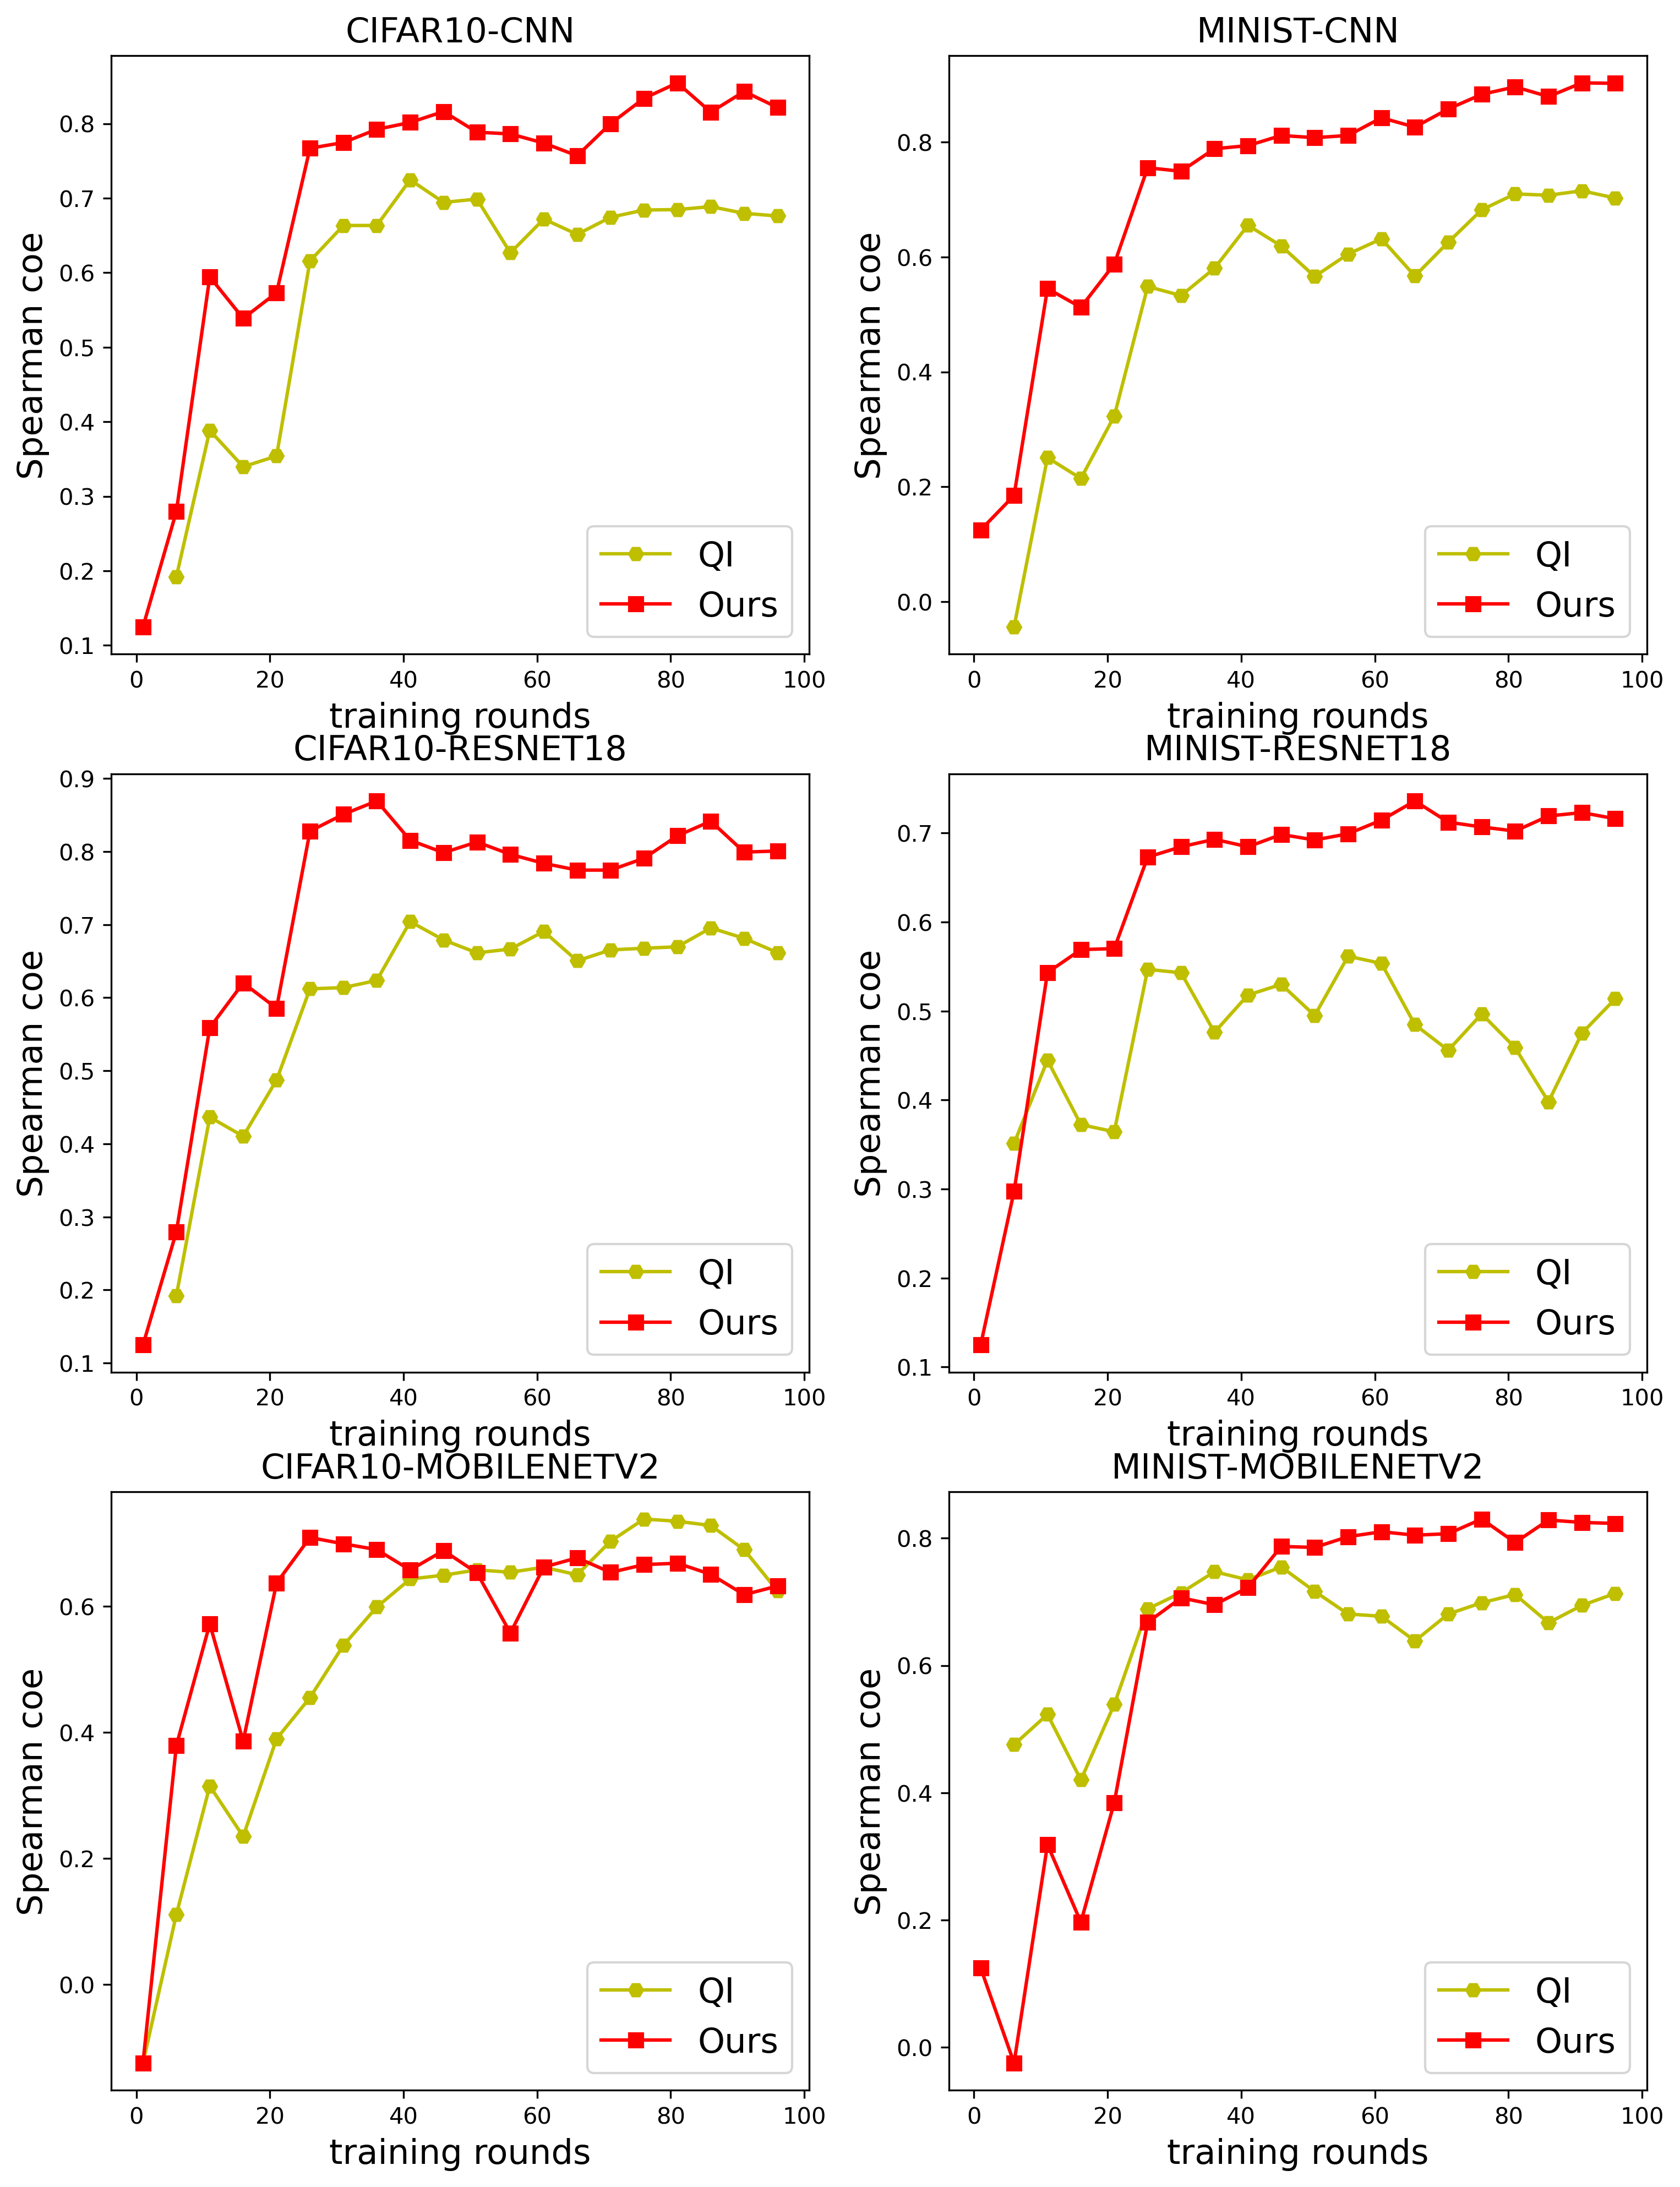

In [8]:
def getScoreSpearman(client_setting,dst_name,net_name,id,method, acc_data_dir="acc_data"):
    data_dict = {}
    bound = 5
    data_dir = acc_data_dir + str(id)
    noise = 'noise'
    iid = 'iid'
    res = torch.load(f'{data_dir}/{net_name}-{dst_name}-{client_setting}-{noise}-{iid}.save')
    res['bound'] = bound
    res['v6flag'] = False
    
    scores = calc_scores(res,method)['scores']
    return scores

def getNormAndSpearman(scores, round):
    scores = normScores(scores,round)
    return showSpearman(scores, client_setting)[0]

fig3 = plt.figure(figsize=(12,16), dpi=300)
axs = fig3.subplots(3, 2)
dsts = ['CIFAR10', 'MINIST']
nets = ['CNN', 'RESNET18', 'MOBILENETV2']
client_setting = 25
id = 8
for netId in range(len(nets)):
    for dstId in range(len(dsts)):
        method = 'V5'
        scores = getScoreSpearman(client_setting, dsts[dstId], nets[netId], id, method, 'acc_data')
        ours = [getNormAndSpearman(scores, round) for round in range(1,101)]
        method = 'origin'
        scores = getScoreSpearman(client_setting, dsts[dstId], nets[netId], id, method, 'acc_data')
        baseline = [getNormAndSpearman(scores, round) for round in range(1,101)]

        x = [i for i in range(1,101)]
        ours = ours[:-1:5]
        baseline = baseline[:-1:5]
        x = x[:-1:5]

        ax = axs[netId][dstId]
        ax.plot(x, baseline, 'yH-')
        ax.plot(x, ours, 'rs-')
        ax.legend(labels = ('QI', 'Ours'), loc = 'lower right', fontsize = 15)
        ax.set_title(dsts[dstId] + "-" + nets[netId])
        ax.set_xlabel('training rounds')
        ax.set_ylabel('Spearman coe')
        ax.title.set_size(15)
        ax.xaxis.label.set_fontsize(15)
        ax.yaxis.label.set_fontsize(15)

fig3.show()
# fig3.savefig("./fig3.pdf", bbox_inches='tight')

/tmp/ipykernel_9728/2900508310.py:64: RuntimeWarning: invalid value encountered in double_scalars
  cov = std/mean


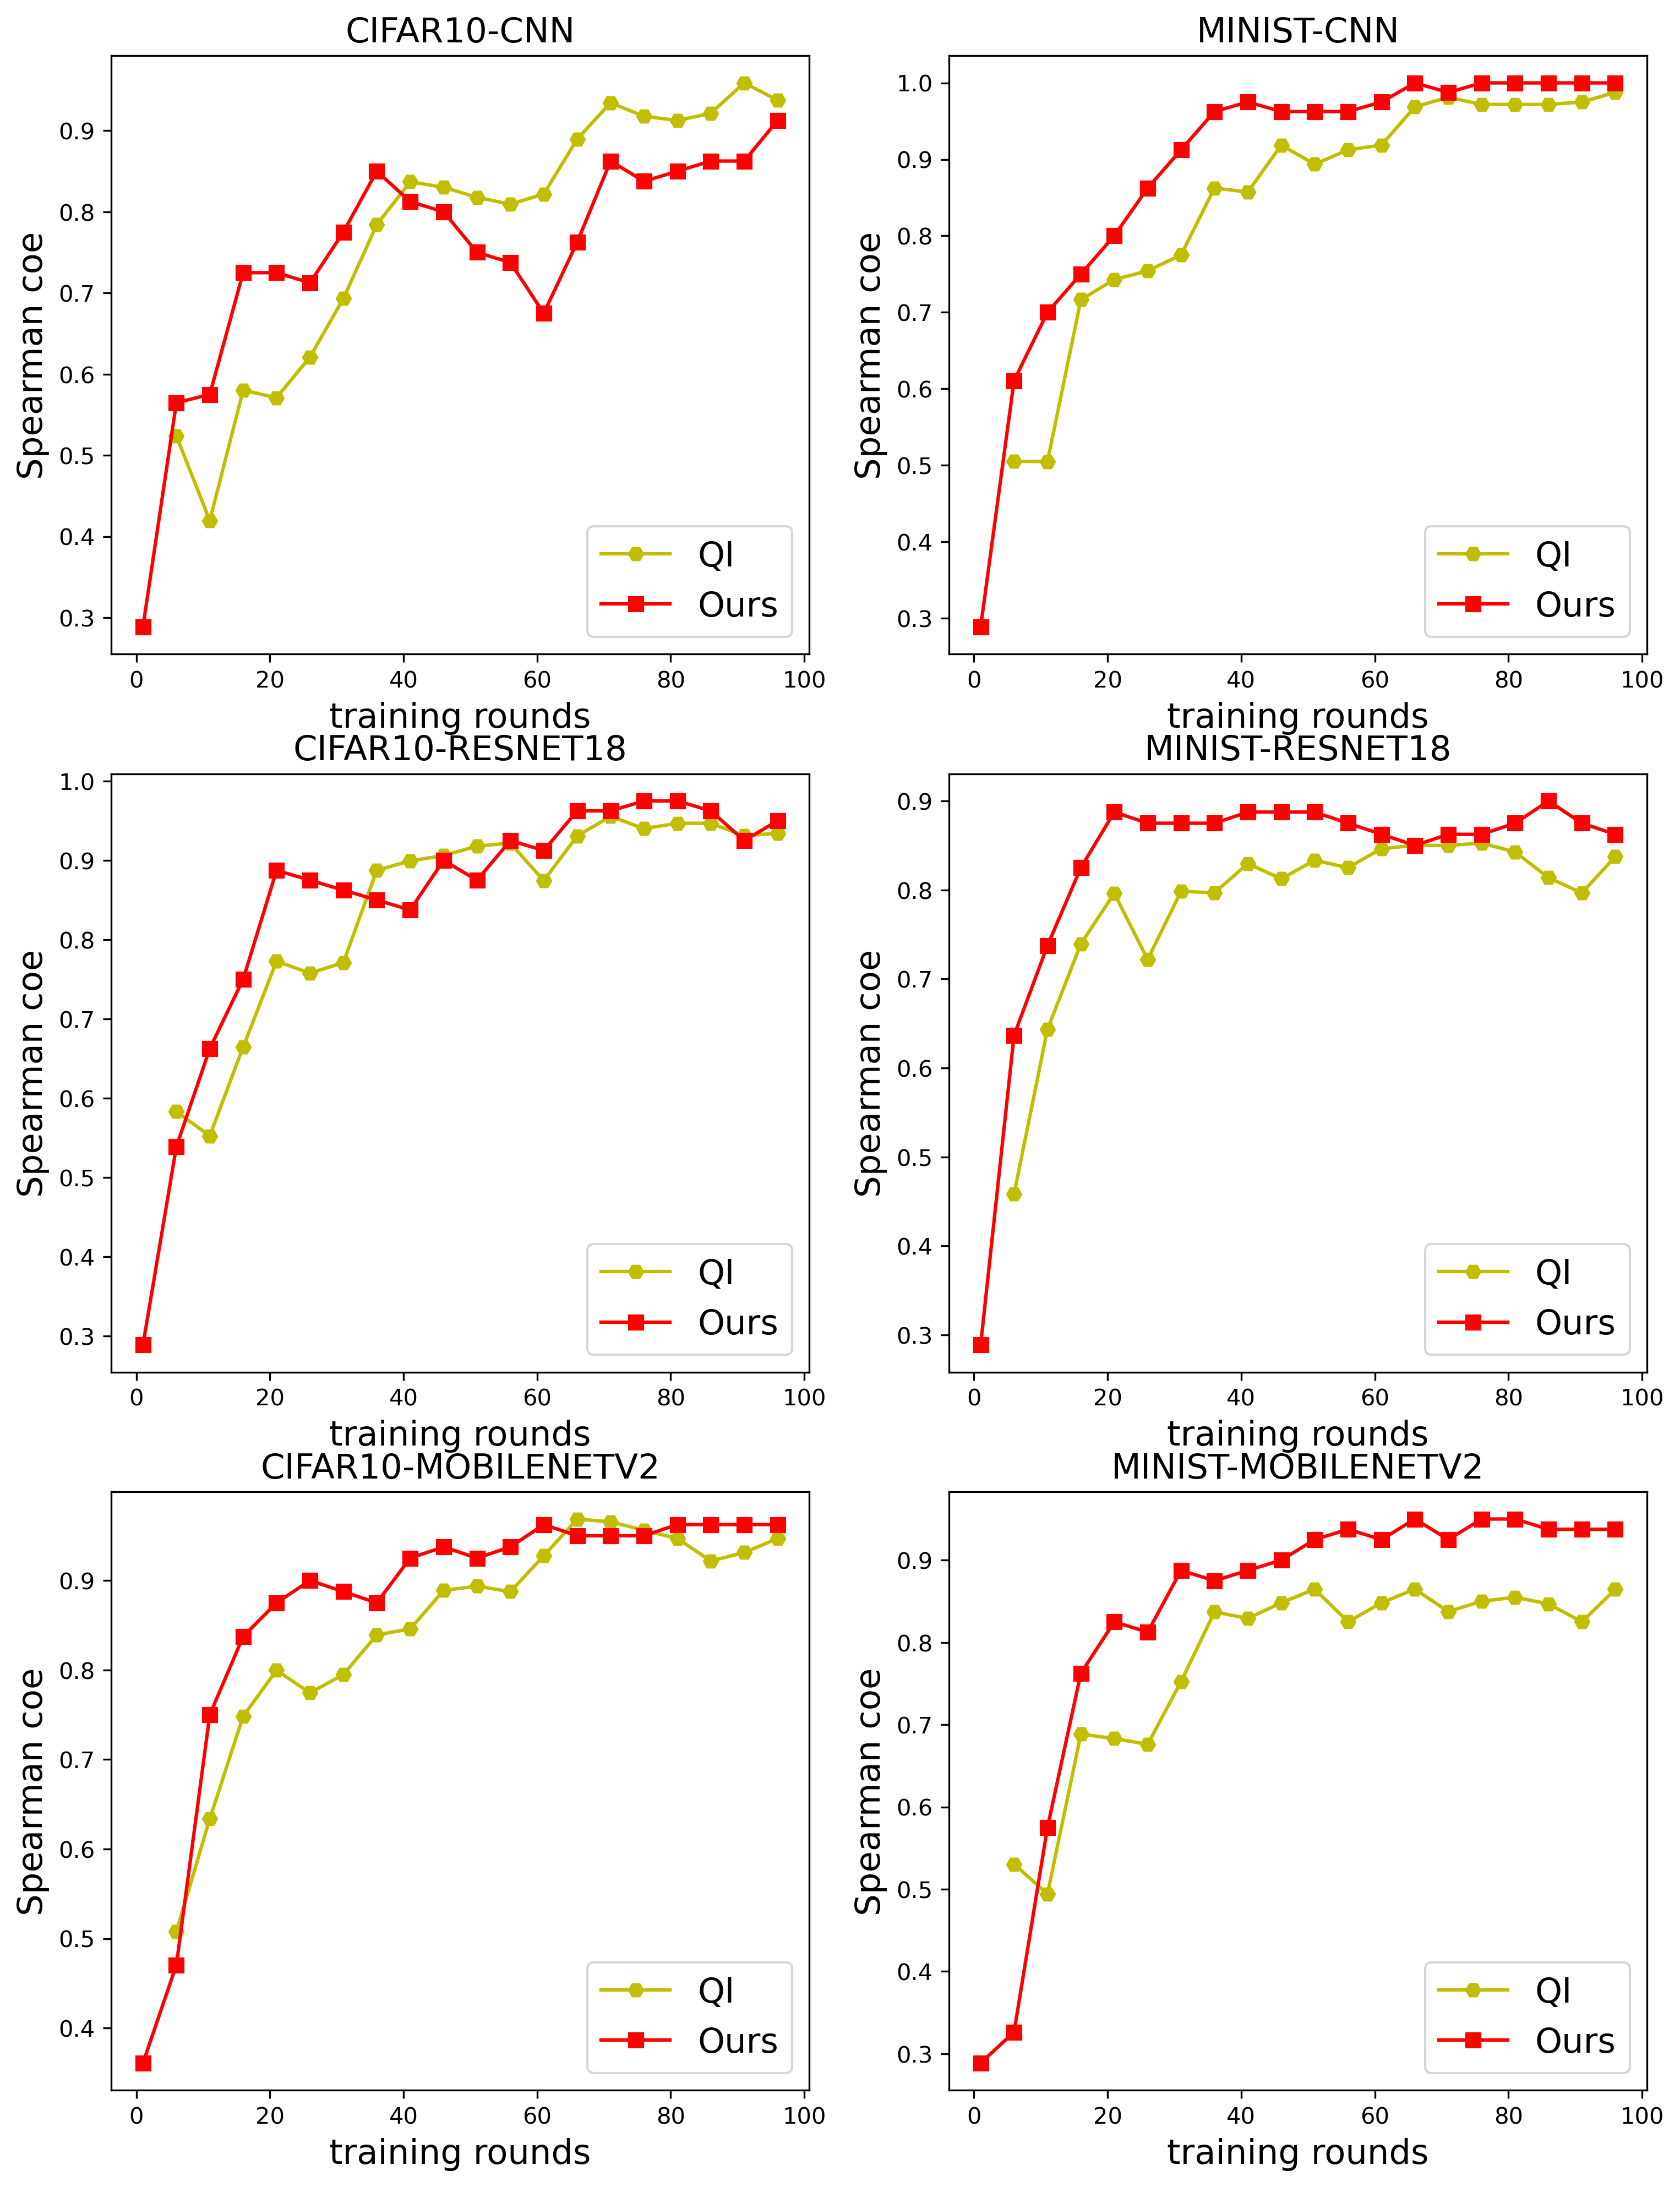

In [9]:
# 测试多个id平均
fig3 = plt.figure(figsize=(12,16), dpi=300)
axs = fig3.subplots(3, 2)
dsts = ['CIFAR10', 'MINIST']
nets = ['CNN', 'RESNET18', 'MOBILENETV2']
ids = [5,6,7,8,9,10,11,12]
ids_ = [6, 8, 15, 17, 19, 20, 21]
client_setting = 5
id = 25
for netId in range(len(nets)):
    for dstId in range(len(dsts)):
        avgbaseline = [0 for i in range(20)]
        avgours = [0 for i in range(20)]
        new_ids = ids
        for id in new_ids:
            method = 'V5'
            scores = getScoreSpearman(client_setting, dsts[dstId], nets[netId], id, method, 'acc_data')
            ours = [getNormAndSpearman(scores, round) for round in range(1,100)]
            method = 'origin'
            scores = getScoreSpearman(client_setting, dsts[dstId], nets[netId], id, method, 'acc_data')
            baseline = [getNormAndSpearman(scores, round) for round in range(1,100)]

            x = [i for i in range(1,101)]
            ours = ours[:-1:5]
            baseline = baseline[:-1:5]
            x = x[:-1:5]

            for i in range(len(ours)):
                avgbaseline[i] += baseline[i]
                avgours[i] += ours[i]
        for i in range(len(ours)):
            avgbaseline[i] /= len(new_ids)
            avgours[i] /= len(new_ids)
        ax = axs[netId][dstId]
        ax.plot(x, avgbaseline, 'yH-')
        ax.plot(x, avgours, 'rs-')
        ax.legend(labels = ('QI', 'Ours'), loc = 'lower right', fontsize = 15)
        ax.set_title(dsts[dstId] + "-" + nets[netId])
        ax.set_xlabel('training rounds')
        ax.set_ylabel('Spearman coe')
        ax.title.set_size(15)
        ax.xaxis.label.set_fontsize(15)
        ax.yaxis.label.set_fontsize(15)

fig3.show()
fig3.savefig("./fig3.pdf", bbox_inches='tight')

/home/user/anaconda3/envs/qi/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/tmp/ipykernel_9728/2900508310.py:64: RuntimeWarning: invalid value encountered in double_scalars
  cov = std/mean


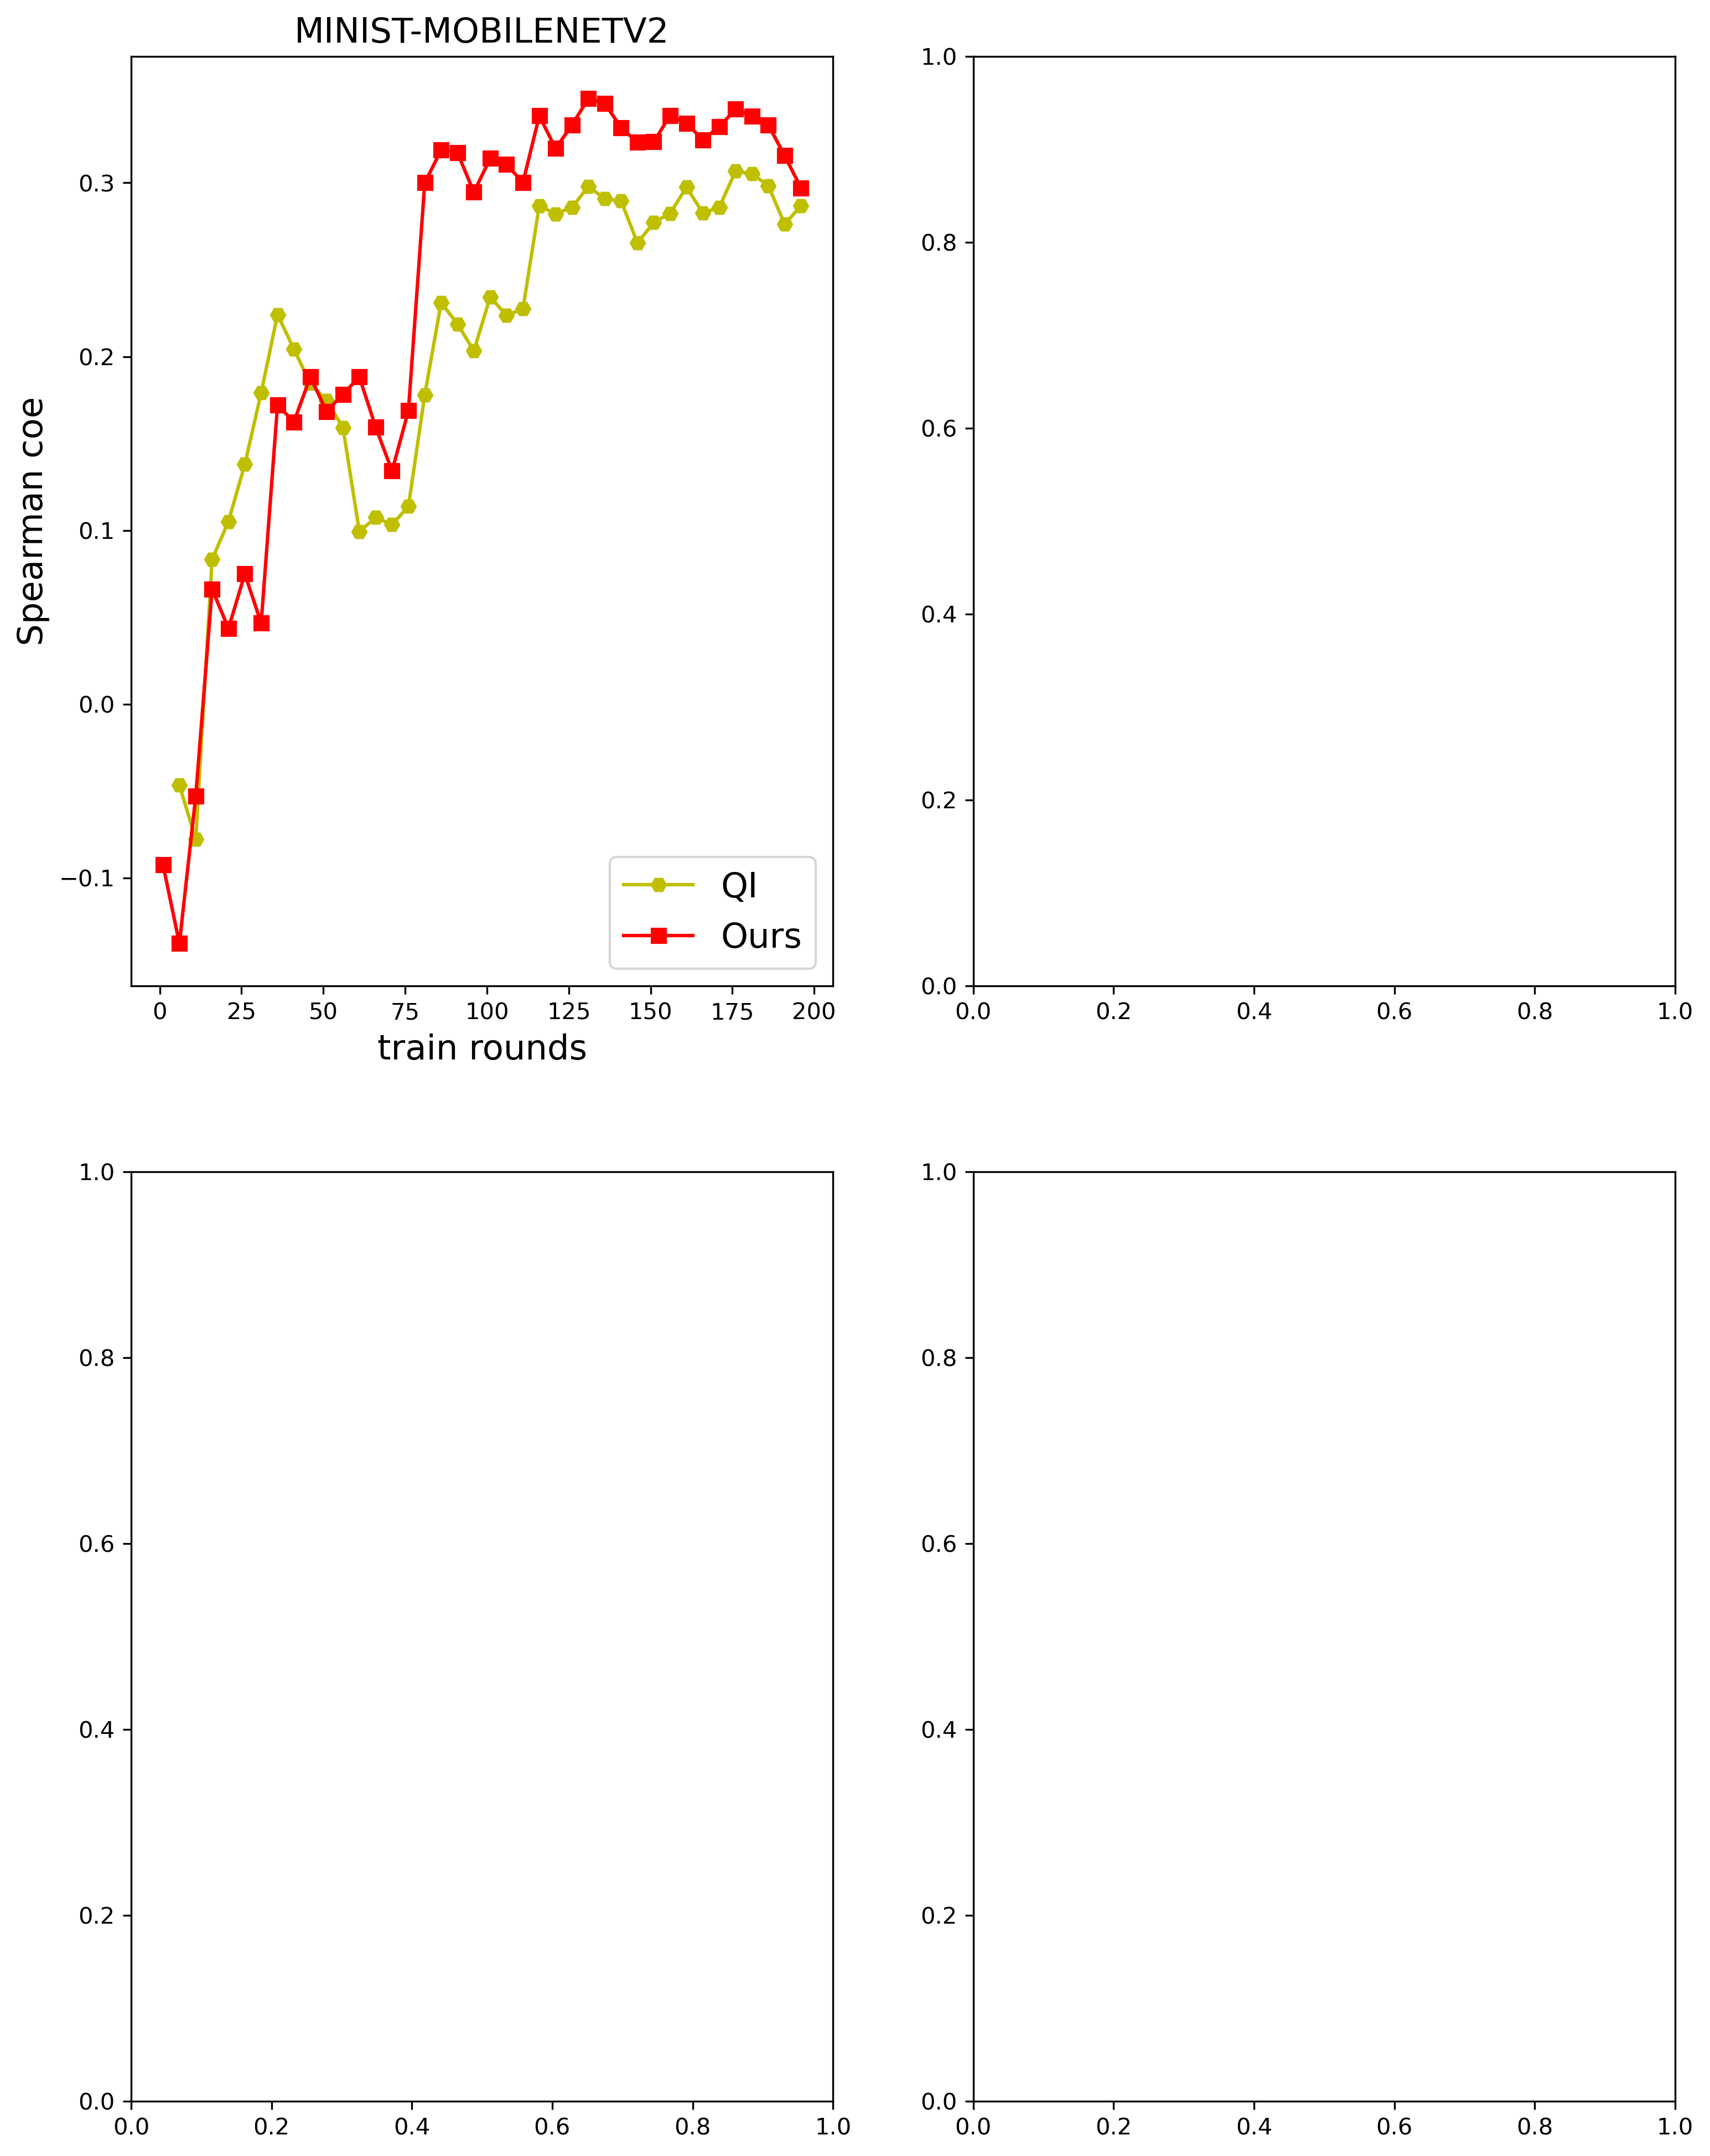

In [10]:
figtest = plt.figure(figsize=(12,16), dpi=300)
axs = figtest.subplots(2,2)
dsts = ['MINIST']
nets = ['MOBILENETV2']
client_setting = 100
id = 105
for netId in range(len(nets)):
    for dstId in range(len(dsts)):
        method = 'V5'
        scores = getScoreSpearman(client_setting, dsts[dstId], nets[netId], id, method, 'acc_data')
        ours = [getNormAndSpearman(scores, round) for round in range(1,len(scores[0]))]
        method = 'origin'
        scores = getScoreSpearman(client_setting, dsts[dstId], nets[netId], id, method, 'acc_data')
        baseline = [getNormAndSpearman(scores, round) for round in range(1,len(scores[0]))]

        x = [i for i in range(1,len(scores[0]))]
        ours = ours[:-1:5]
        baseline = baseline[:-1:5]
        x = x[:-1:5]

        ax = axs[netId][dstId]
        ax.plot(x, baseline, 'yH-')
        ax.plot(x, ours, 'rs-')
        ax.legend(labels = ('QI', 'Ours'), loc = 'lower right', fontsize = 15)
        ax.set_title(dsts[dstId] + "-" + nets[netId])
        ax.set_xlabel('train rounds')
        ax.set_ylabel('Spearman coe')
        ax.title.set_size(15)
        ax.xaxis.label.set_fontsize(15)
        ax.yaxis.label.set_fontsize(15)

figtest.show()
# figtest.savefig("./fig3.pdf", bbox_inches='tight')

In [11]:
def aggScores(client_setting,dst_name,net_name,ids,method,acc_data_dir="acc_data"):
    data_dict = {}
    bound = 5
    for id in ids:
        data_dir = acc_data_dir + str(id)
        noise = 'noise'
        iid = 'iid'
        res = torch.load(f'{data_dir}/{net_name}-{dst_name}-{client_setting}-{noise}-{iid}.save')
        res['bound'] = bound
        res['v6flag'] = False

        # print(type(calc_scores),type(res),type(method))
        scores = calc_scores(res,method)['scores']
        scores = normScores(scores,100)
        
        for i in range(len(scores)):
            if i not in data_dict:
                data_dict[i] = []
            data_dict[i].append(scores[i])
    data_key = dst_name + '-' + net_name + '-' + str(client_setting) + '-' + method
    data = []
    label = []
    for i in data_dict:
        data.append(data_dict[i])
        label.append(i)
    return data_key,data,label

In [12]:
# for client in [5,25,100]:
#     for dst in ['MINIST','CIFAR10']:
#         for net in ['CNN','RESNET18']:
#             graph_title,scores,lebel = aggScores(client,dst,net,[5,6,7,8,9,10,11,12],'V5')
#             plt.figure(figsize=(12,5))
#             # ax = plt.subplot(1,2,1)
#             # ax.set_title(graph_title)
#             plt.title(graph_title)
#             plt.boxplot(scores,showbox=False,labels=lebel)
#             plt.show()

#             graph_title,scores,lebel = aggScores(client,dst,net,[5,6,7,8,9,10,11,12],'origin')
#             plt.figure(figsize=(12,5))
#             # ax = plt.subplot(1,2,2)
#             # ax.set_title(graph_title)
#             plt.title(graph_title)
#             plt.boxplot(scores,labels=lebel)
#             plt.show()

graph_title,scores,lebel = aggScores(100,'MINIST','MOBILENETV2',[5],'V5')
# plt.figure(figsize=(15,5))
# plt.title(graph_title)
# plt.boxplot(scores,labels=lebel,sym='',widths=0.03,patch_artist=True,showmeans=True,
#             boxprops=dict(facecolor='black'),
#             meanprops=dict(marker='o',markerfacecolor='w'))
# plt.show()

In [13]:
def aggQi(clientSetting = [25], dst= ['CIFAR10'], ids=[5,6,7,8,9,10,11,12], nets=['RESNET18','CNN','MOBILENETV2']):
    # clientSetting = [25]
    # dst = ['CIFAR10']
    # nets = ['RESNET18','CNN','MOBILENETV2']
    # ids = [5,6,7,8,9,10,11,12]
    data = {}
    for id in ids:
        data_dir = "acc_data"+str(id)
        for n_p in clientSetting:
            for dst_name in dst:
                for netName in nets:
                    bound = 5
                    # netName = "MOBILENETV2"
                    noise = 'noise'
                    iid = 'iid'
                    res = torch.load(f'{data_dir}/{netName}-{dst_name}-{n_p}-{noise}-{iid}.save')
                    res['bound'] = bound
                    res['v6flag'] = False
                    b = calc_scores(res,'origin')['scores']
                    v5 = calc_scores(res,'V5')['scores']
                    # v7 = calc_scores(res,'V7')['scores']
                    b = normScores(b,len(b[0])-1)
                    v5 = normScores(v5,len(v5[0])-1)
                    # v7 = normScores(v7,100)

                    sb,stdb = showSpearman(b,res['client_n'])
                    sv5,stdv5 = showSpearman(v5,res['client_n'])
                    # sv7,stdv7 = showSpearman(v7,res['client_n'])
                    keybase = 'QI'+'-'+netName+'-'+dst_name+'-'+str(n_p)
                    keyv5 = 'Ours'+'-'+netName+'-'+dst_name+'-'+str(n_p)
                    # keyv7 = 'v7'+'-'+netName[0]+'-'+dst_name[0]+'-'+str(n_p)
                    if keyv5 not in data:
                        data[keyv5] = []
                    if keybase not in data:
                        data[keybase] = []
                    # if keyv7 not in data:
                    #     data[keyv7] = []
                    data[keyv5].append(sv5)
                    data[keybase].append(sb)
                    # data[keyv7].append(sv7)
    return data



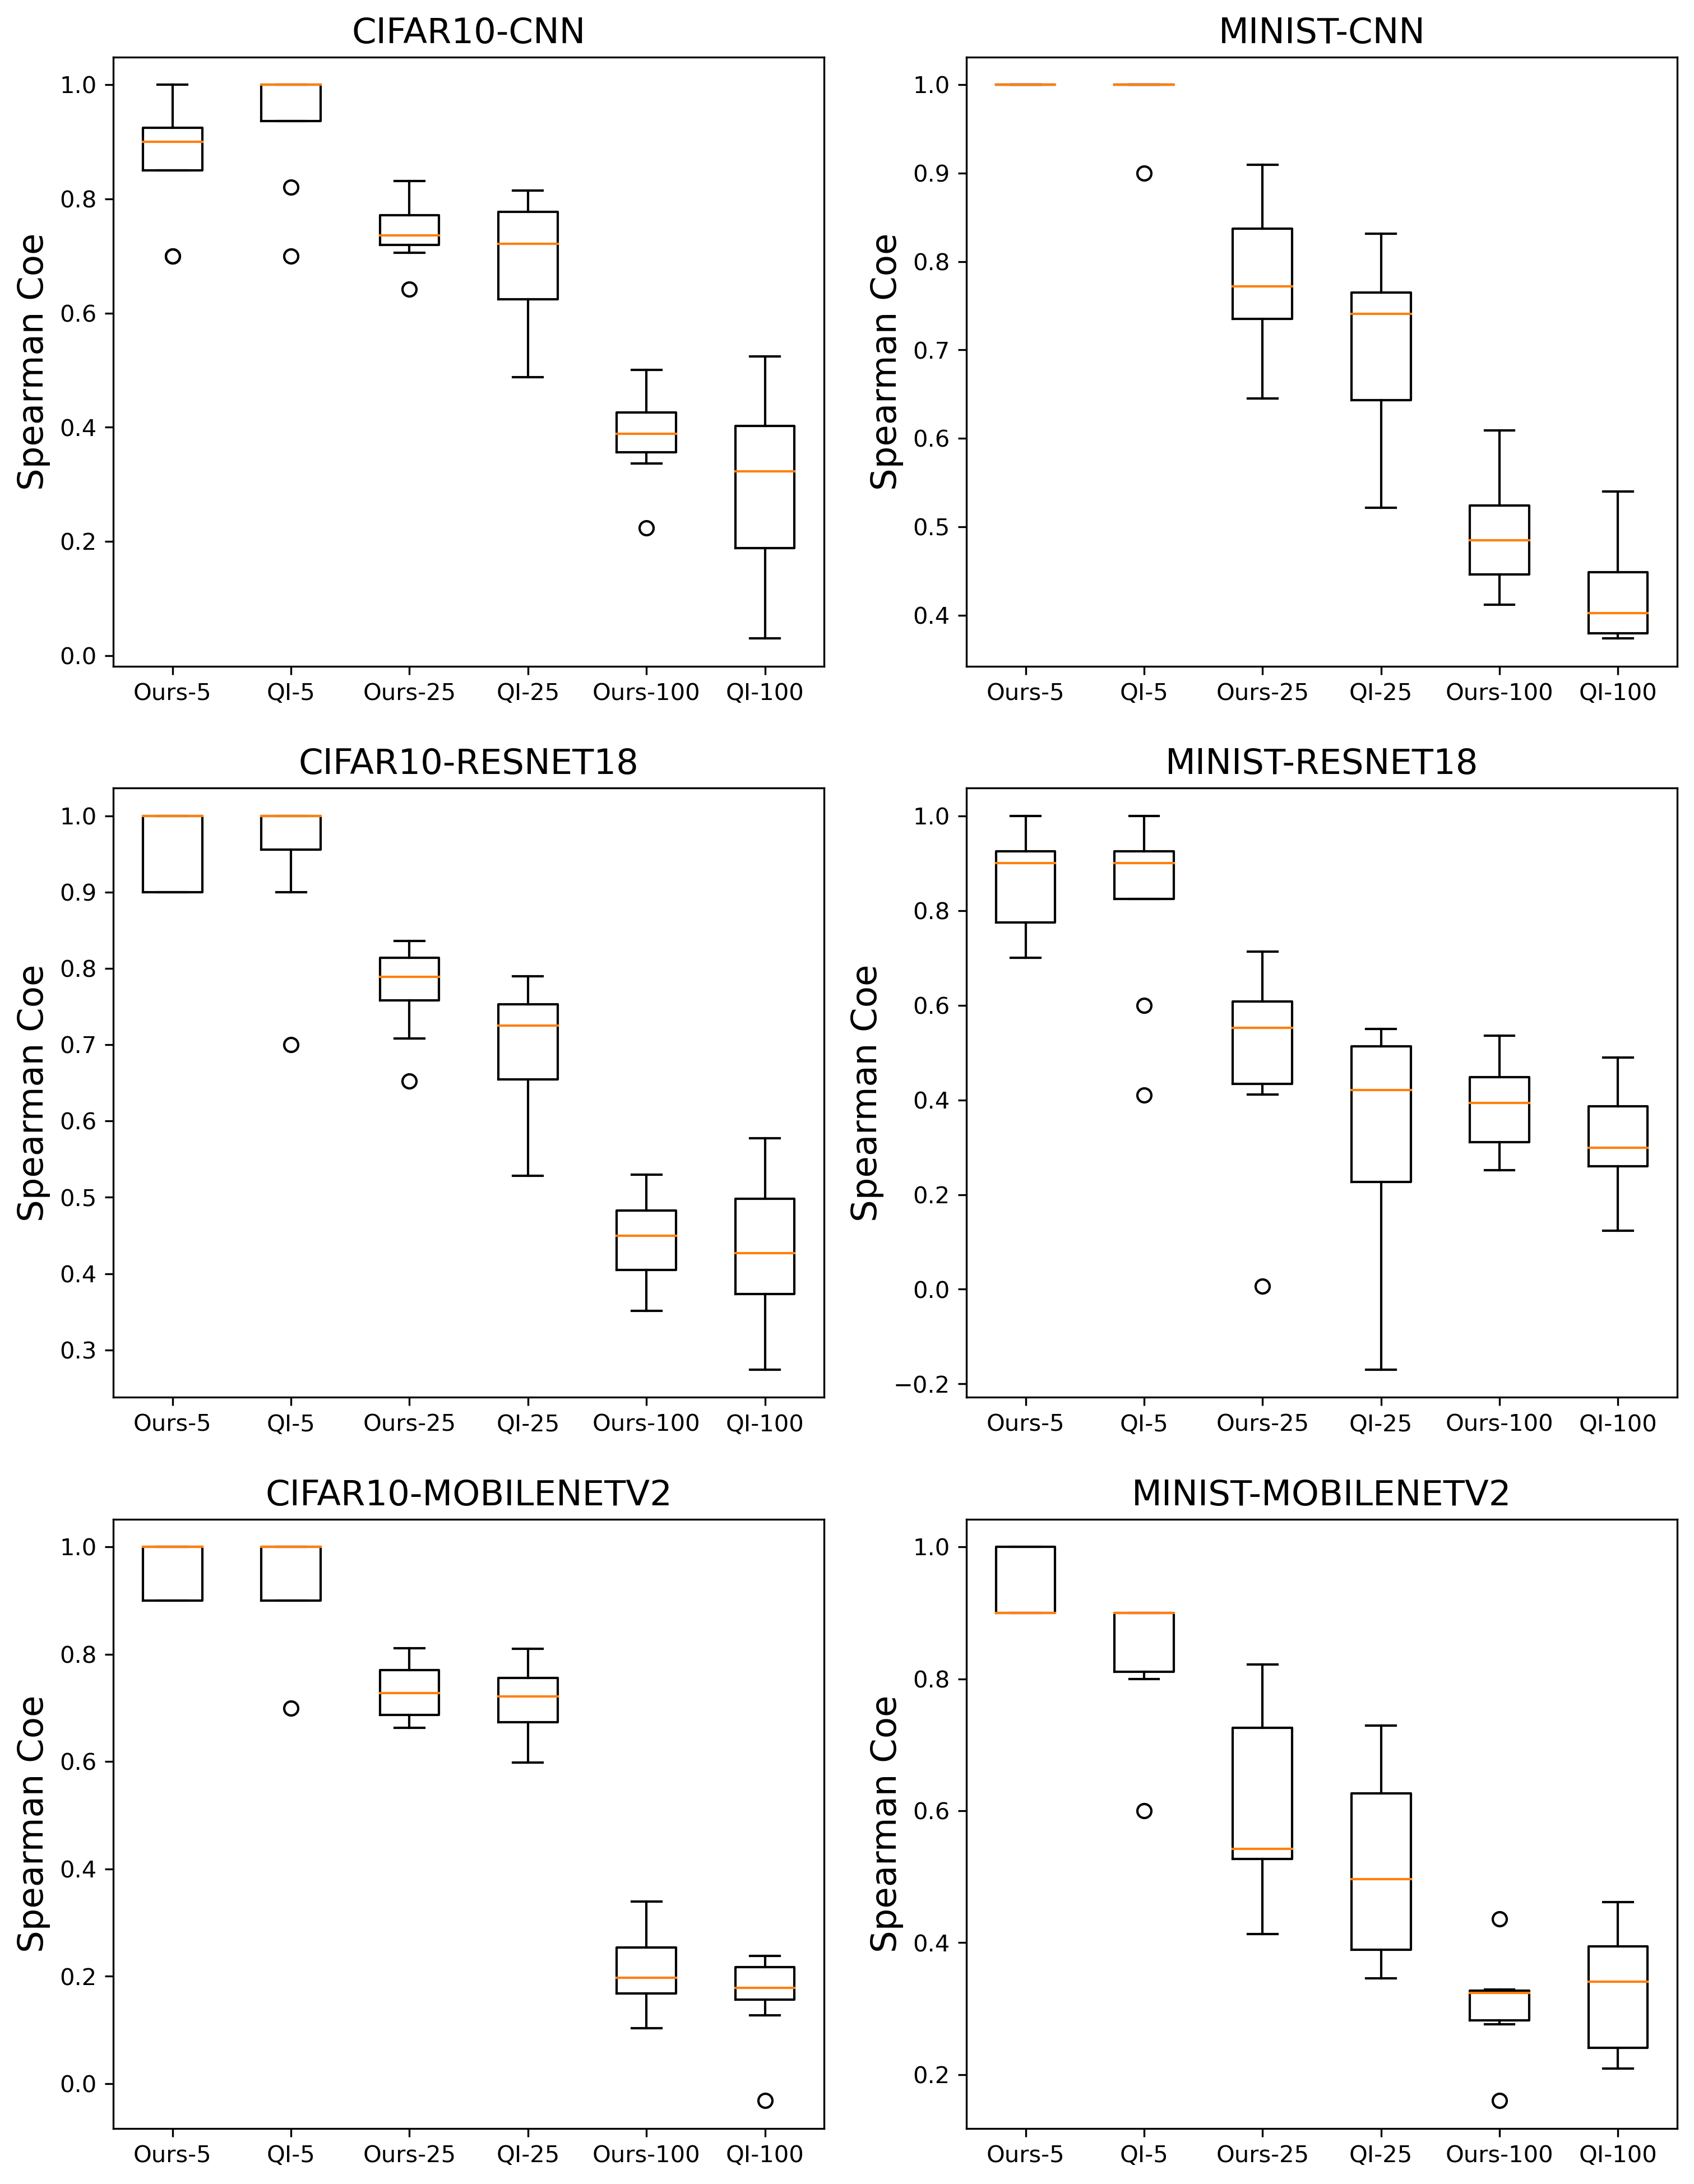

In [14]:
def getNetDst(data, net, dst):
    dlist = []
    label = []
    for i in data:
        if net+'-'+dst in i:
            ii = i.split('-')
            label.append(ii[0]+'-'+ii[-1])
            dlist.append(data[i])
    return dlist,label
# Figure 2
# sub fig1: CNN-MINIST 5,25,100对比(Ours vs QI)
# sub fig2: CNN-CIFAR10 5,25,100对比(Ours vs QI)
# sub fig3: RESNET18-MINIST 5,25,100对比(Ours vs QI)
# sub fig4: RESNET18-CIFAR10 5,25,100对比(Ours vs QI)
# sub fig5: MOBILENET-MINIST 5,25,100对比(Ours vs QI)
# sub fig6: MOBILENET-CIFAR10 5,25,100对比(Ours vs QI)
data = aggQi(clientSetting=[5, 25, 100], dst=['CIFAR10', 'MINIST'])
data_ = aggQi(clientSetting=[5, 25, 100], dst=['MINIST'], ids=[6, 8, 15, 17, 19, 20, 21], nets=['MOBILENETV2'])
# dlist, label = getNetDst(data, 'MOBILENETV2','CIFAR10')
fig2 = plt.figure(figsize=(12,16), dpi=300)
axs = fig2.subplots(3, 2)
dsts = ['CIFAR10', 'MINIST']
nets = ['CNN', 'RESNET18', 'MOBILENETV2']
for netId in range(len(nets)):
    for dstId in range(len(dsts)):
        if nets[netId] == 'MOBILENETV2' and dsts[dstId] == 'MINIST':
            dlist, label = getNetDst(data_, nets[netId], dsts[dstId])
        else:
            dlist, label = getNetDst(data, nets[netId], dsts[dstId])
        ax = axs[netId][dstId]
        ax.boxplot(dlist,labels=label)
        ax.set_title(dsts[dstId] + "-" + nets[netId])
        ax.set_ylabel('Spearman Coe')
        ax.yaxis.label.set_fontsize(15)
        ax.title.set_size(15)

fig2.show()
fig2.savefig("./fig2.pdf", bbox_inches='tight')

In [15]:
new_data = {}
for i in  data:
    if 'MOBILENETV2' in i and 'MINIST' in i:
        new_data[i] = data_[i]
    else:
        new_data[i] = data[i]

In [19]:
# accuracy improvements
ours = [0,0,0]
qi = [0,0,0]
ps = ["100", "25", "5"]
for i in new_data:
    if "Ours" in i:
        if "-100" in i:
            ours[0] += sum(new_data[i])
        elif "-25" in i:
            ours[1] += sum(new_data[i])
        else:
            ours[2] += sum(new_data[i])
    else:
        if "-100" in i:
            qi[0] += sum(new_data[i])
        elif "-25" in i:
            qi[1] += sum(new_data[i])
        else:
            qi[2] += sum(new_data[i])
print([(ours[i]-qi[i])/qi[i] for i in range(3)])
print(ours)
print(qi)
np.average([(ours[i]-qi[i])/qi[i] for i in range(3)])

[0.14021261220729714, 0.13264332947727087, 0.023278643405829375]
[17.48852085208521, 32.431538461538466, 43.89999999999999]
[15.337947208134983, 28.633496192050174, 42.901315573132095]


0.09871152836346579

In [18]:
# stability
ours = [0,0,0]
qi = [0,0,0]
ps = ["100", "25", "5"]
for i in new_data:
    if "Ours" in i:
        if "-100" in i:
            ours[0] += np.var(new_data[i])
        elif "-25" in i:
            ours[1] += np.var(new_data[i])
        else:
            ours[2] += np.var(new_data[i])
    else:
        if "-100" in i:
            qi[0] += np.var(new_data[i])
        elif "-25" in i:
            qi[1] += np.var(new_data[i])
        else:
            qi[2] += np.var(new_data[i])
print([(qi[i]-ours[i])/qi[i] for i in range(3)])
print(ours)
print(qi)
np.average([(qi[i]-ours[i])/qi[i] for i in range(3)])

[0.4610247514512777, 0.3319055357025679, 0.6121171109185953]
[0.03378990553563154, 0.07642343542446565, 0.03135522959183673]
[0.06269287064037969, 0.11439016412870973, 0.08083684657008995]


0.46834913269081363

In [101]:
# stability of every situation
dsts = ['CIFAR10', 'MINIST']
nets = ['CNN', 'RESNET18', 'MOBILENETV2']
ps = ["100", "25", "5"]
so = 0
sq = 0
for netId in range(len(nets)):
    for dstId in range(len(dsts)):
        for psId in range(len(ps)):
            ours = np.var(new_data["Ours-" + nets[netId] + "-" + dsts[dstId] + "-" + ps[psId]])
            qi = np.var(new_data["QI-" + nets[netId] + "-" + dsts[dstId] + "-" + ps[psId]])
            print(nets[netId] + "-" + dsts[dstId] + "-" + ps[psId], ours, qi, (qi-ours)/qi)
            so += ours
            sq += qi
print(so, sq, (sq-so)/sq)

CNN-CIFAR10-100 0.006370045816462836 0.023523790102551487 0.7292083550867973
CNN-CIFAR10-25 0.003097401997041424 0.011943565196955417 0.740663533378543
CNN-CIFAR10-5 0.011874999999999991 0.01136752108727165 -0.044642882897008344
CNN-MINIST-100 0.004130585551804504 0.004115806435726394 -0.003590819031192317
CNN-MINIST-25 0.005972041420118346 0.00930099022773339 0.35791337546930135
CNN-MINIST-5 0.0 0.0010937500000000018 1.0
RESNET18-CIFAR10-100 0.003704932021104902 0.008125591349680454 0.5440415519726326
RESNET18-CIFAR10-25 0.0035187037721893548 0.009090350555485033 0.6129188032175281
RESNET18-CIFAR10-5 0.0023437500000000043 0.009753616638315117 0.7597045191633784
RESNET18-MINIST-100 0.009168871873686016 0.011907615905419883 0.22999935952647727
RESNET18-MINIST-25 0.04275812684911243 0.05910728368916349 0.27660139021154945
RESNET18-MINIST-5 0.012343749999999992 0.038282730344979476 0.6775634891041988
MOBILENETV2-CIFAR10-100 0.004625101168982784 0.00666720267514801 0.306290599770899
MOBILE

{'Ours-RESNET18-CIFAR10-5': [0.9999999999999999,
  0.9999999999999999,
  0.8999999999999998,
  0.8999999999999998,
  0.9999999999999999,
  0.9999999999999999,
  0.9999999999999999,
  0.8999999999999998],
 'QI-RESNET18-CIFAR10-5': [0.8999999999999998,
  0.9999999999999999,
  0.9999999999999999,
  0.9999999999999999,
  0.9999999999999999,
  0.7,
  0.9999999999999999,
  0.9746794344808963],
 'Ours-CNN-CIFAR10-5': [0.8999999999999998,
  0.9999999999999999,
  0.7,
  0.7,
  0.8999999999999998,
  0.8999999999999998,
  0.9999999999999999,
  0.9999999999999999],
 'QI-CNN-CIFAR10-5': [0.9746794344808963,
  0.9999999999999999,
  0.9999999999999999,
  0.8207826816681234,
  0.9999999999999999,
  0.9999999999999999,
  0.9999999999999999,
  0.7],
 'Ours-MOBILENETV2-CIFAR10-5': [0.9999999999999999,
  0.9999999999999999,
  0.9999999999999999,
  0.9999999999999999,
  0.8999999999999998,
  0.8999999999999998,
  0.9999999999999999,
  0.8999999999999998],
 'QI-MOBILENETV2-CIFAR10-5': [0.9999999999999999,
 

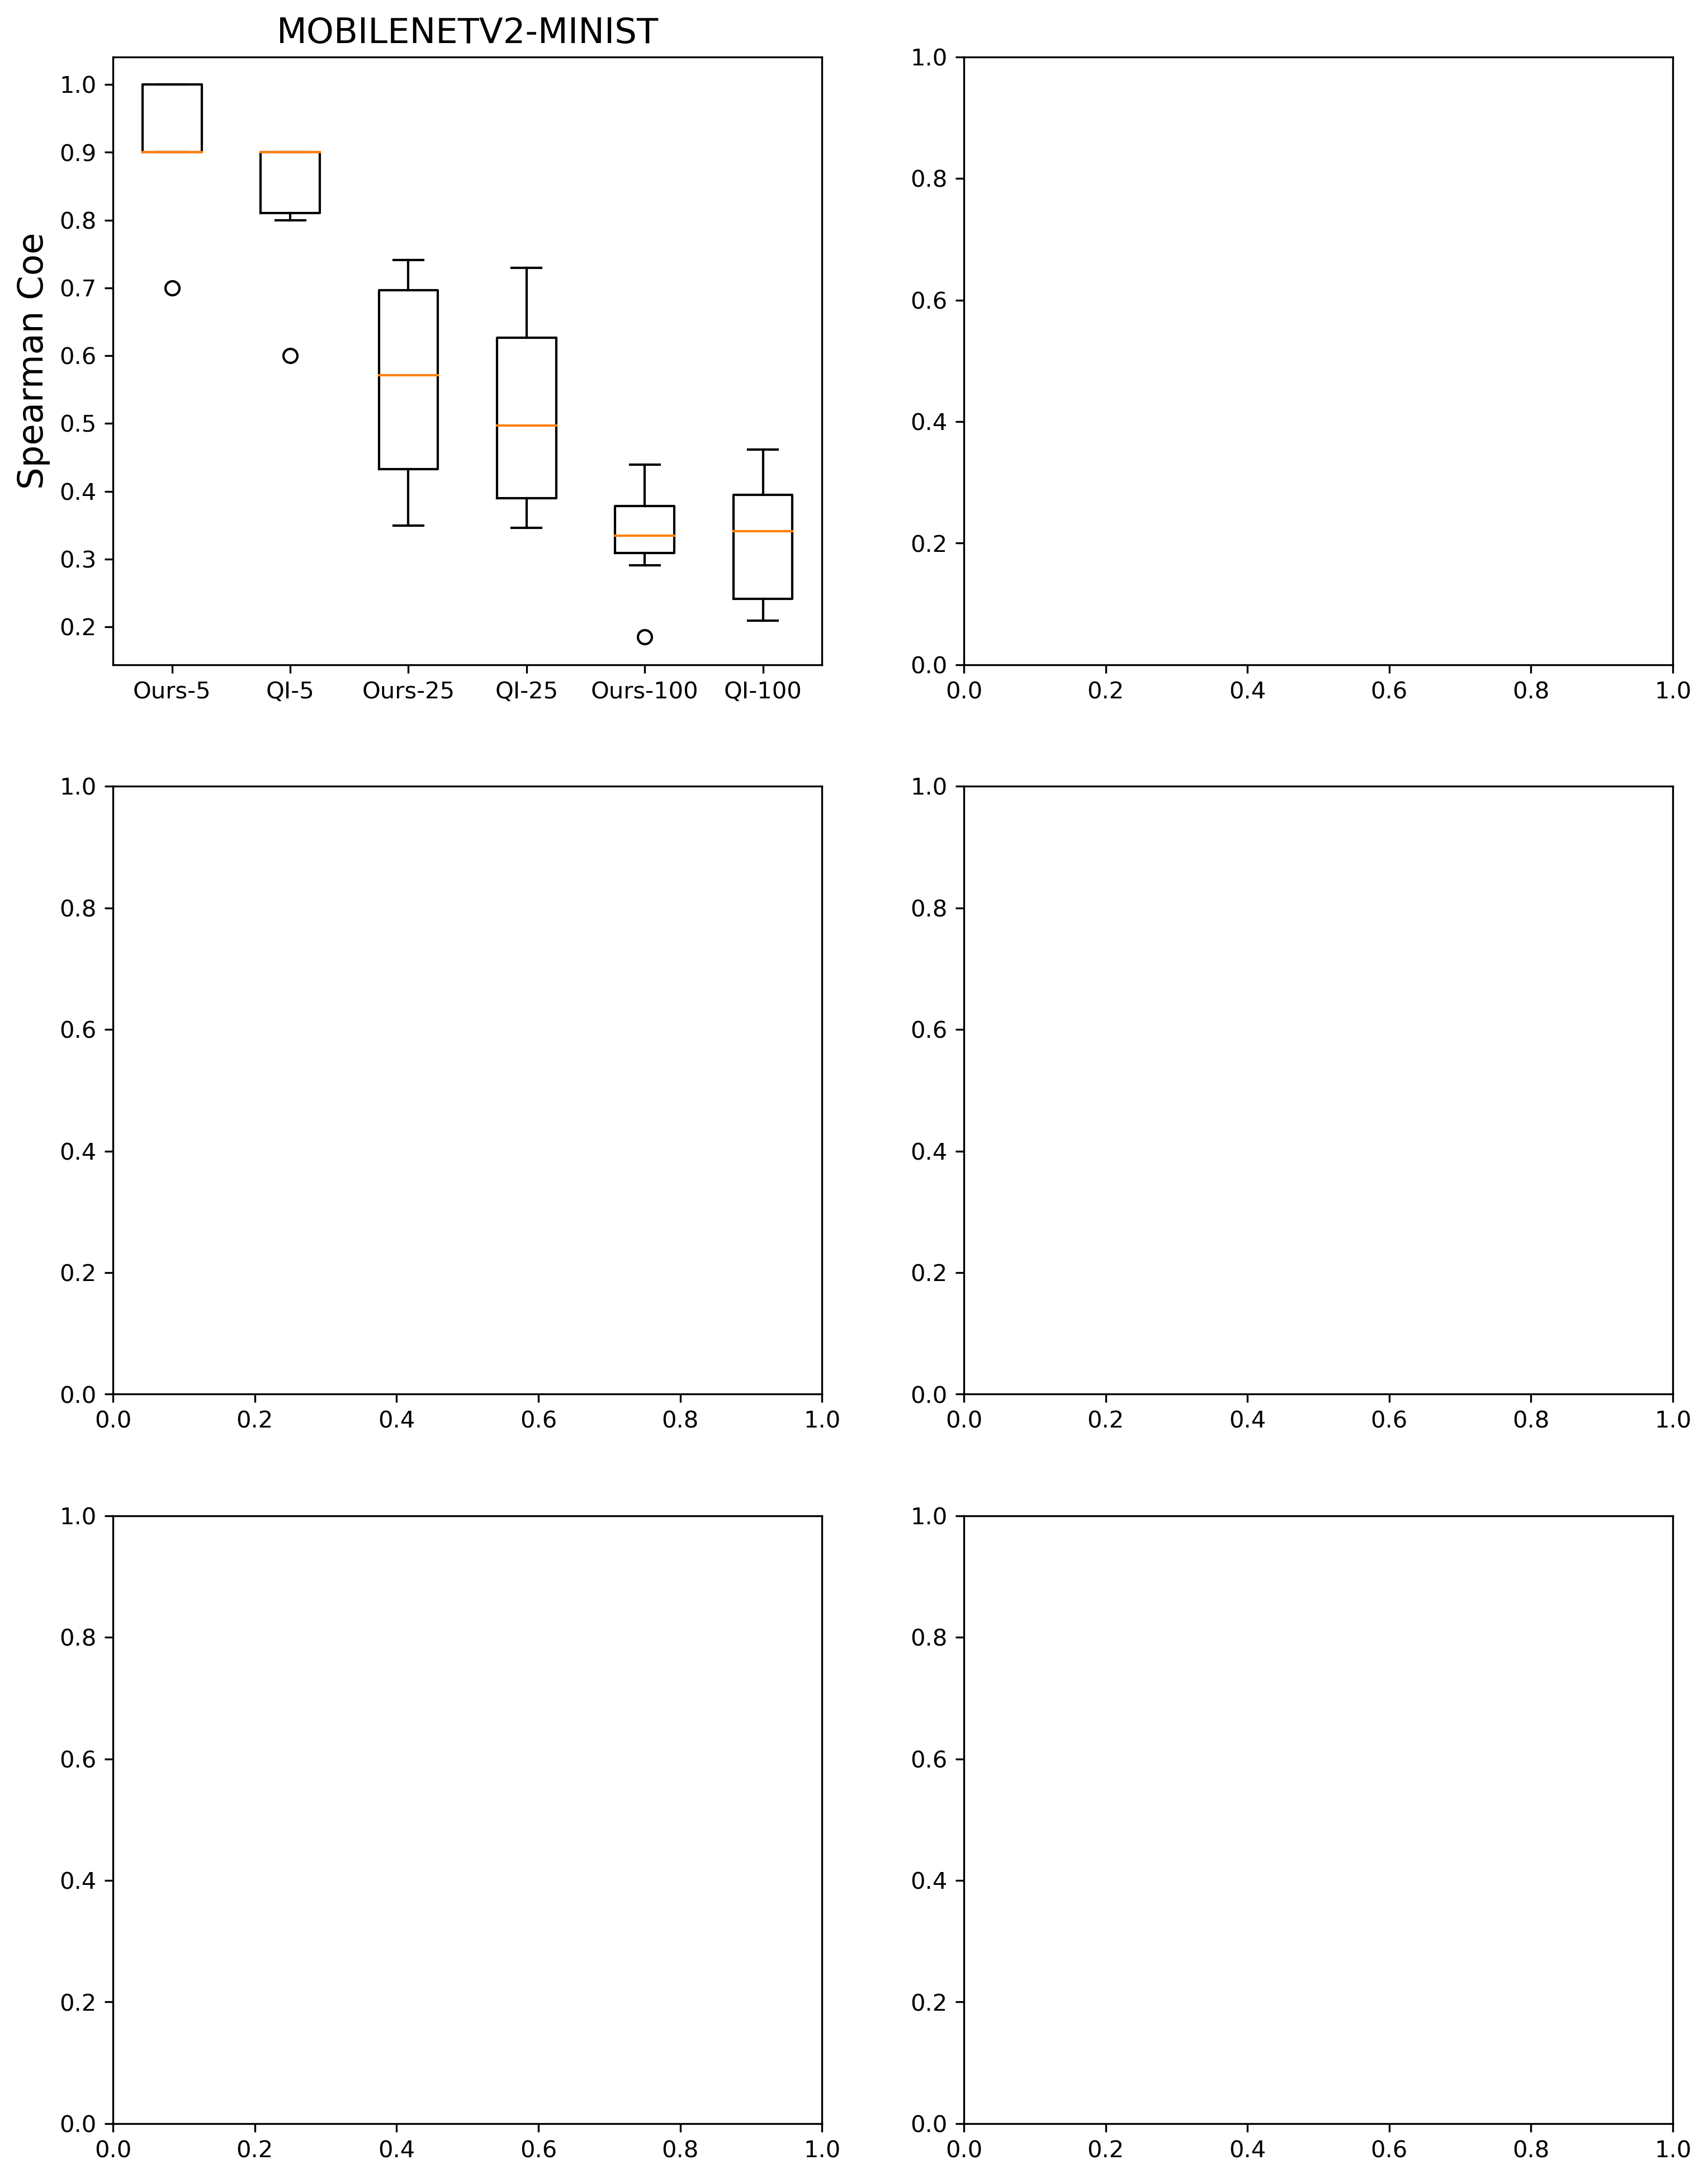

In [56]:
def getNetDst(data, net, dst):
    dlist = []
    label = []
    for i in data:
        if net+'-'+dst in i:
            ii = i.split('-')
            label.append(ii[0]+'-'+ii[-1])
            dlist.append(data[i])
    return dlist,label
# Figure #2
# bad1 6, 8, 15, 17, 19, 20, 21
# bad2 7 9 11 12 16 18  22
# bad3 5 10

data = aggQi(clientSetting=[5, 25, 100], dst=['MINIST'], ids=[6, 8, 15, 17, 19, 20, 21], nets=['MOBILENETV2'])
fig2 = plt.figure(figsize=(12,16), dpi=300)
axs = fig2.subplots(3, 2)
dsts = ['MINIST']
nets = ['MOBILENETV2']
for netId in range(len(nets)):
    for dstId in range(len(dsts)):
        dlist, label = getNetDst(data, nets[netId], dsts[dstId])
        ax = axs[netId][dstId]
        ax.boxplot(dlist,labels=label)
        ax.set_title(nets[netId]+"-"+dsts[dstId])
        ax.set_ylabel('Spearman Coe')
        ax.yaxis.label.set_fontsize(15)
        ax.title.set_size(15)

fig2.show()
# fig2.savefig("./fig2.pdf", bbox_inches='tight')

In [19]:
data_dir = "acc_data13"
log_dir = data_dir + "/board"
writer = SummaryWriter(log_dir)
for n_p in [100,25]:
    for dst_name in ['MINIST','CIFAR10']:
        for netName in ['RESNET18','CNN','MOBILENETV2', 'MLP']:
            noise = 'nonise'
            iid = 'iid'
            res = torch.load(f'{data_dir}/{netName}-{dst_name}-{n_p}-{noise}-{iid}.save')
            for round in range(len(res['acc_logs'])):
                writer.add_scalars(f'Accuracy-{netName}-{dst_name}/Acc-{n_p}-{noise}-{iid}',{'acc':res['acc_logs'][round]},round)
            

In [104]:
dst_name = 'MINIST'
n_p = 5
nn_p = 10
noise = 'noise'
iid = 'iid'
res = torch.load(f'{data_dir}/CNN-{dst_name}-{n_p}-{noise}-{iid}.save')

res['bound'] = 5
b = calc_scores(res,'origin')
v5 = calc_scores(res,'V5')
v7 = calc_scores(res,'V7')
v6 = calc_scores(res, 'V6')
rns = [3,250]
sb,stdb = showSpearman(b['scores'],res['client_n'],rns)
sv5,stdv5 = showSpearman(v5['scores'],res['client_n'],rns)
sv7,stdv7 = showSpearman(v7['scores'],res['client_n'],rns)
sv6,stdv6 = showSpearman(v6['scores'],res['client_n'],rns)
# for i in range(rns[0],rns[1]):
#     print(i,sb[i-rns[0]],sv6[i-rns[0]],sv7[i-rns[0]])
for c in range(0,n_p):
    print('%d b:%.3f, v6:%.3f, v7:%.3f' % (c,b['scores'][c][99],v6['scores'][c][99],v7['scores'][c][99]))

d:\anaconda3\envs\pye\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


0 b:-54.000, v6:-37.000, v7:-28.668
1 b:-13.000, v6:-20.200, v7:-9.587
2 b:-8.000, v6:-8.500, v7:-3.797
3 b:-4.000, v6:-0.800, v7:1.863
4 b:-9.000, v6:-1.700, v7:5.614


In [ ]:
spearman = []
std = []
for r in range(3,4):
    x1 = []
    y1 = []
    for c in range(100):
        x1.append(v6['scores'][c][r])
        y1.append(c)
    spearman.append(scipy.stats.spearmanr(x1,y1)[0])
    std.append(scipy.stats.tstd(x1))
y1

In [8]:
log_dir = 'acc_data2/tmp'
writer = SummaryWriter(log_dir)
for round in range(len(res['acc_logs'])):
    writer.add_scalars(f'Learnning/Acc-{dst_name}-{n_p}-{noise}-{iid}',{'acc':res['acc_logs'][round]},round)
    writer.add_scalars(f'Learnning/Acc-{dst_name}-{n_p}-{noise}-{iid}',{'exp':v5['expAcc_logs'][round]},round)
    writer.add_scalars(f'Learnning/Acc-{dst_name}-{n_p}-{noise}-{iid}',{'avg_idx':(sum(res['ParticipantSet'][round])/nn_p)/(n_p-1)},round)

In [37]:
log_dir = 'acc_data/tmp'
writer = SummaryWriter(log_dir)
for id in range(n_p):
    writer.add_scalars(f'Learnning/Std-{dst_name}-{n_p}-{noise}-{iid}',{'base':b['scores'][id][100]},id)
    writer.add_scalars(f'Learnning/Std-{dst_name}-{n_p}-{noise}-{iid}',{'v6':v6['scores'][id][100]},id)